In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as udata
import torch.optim as optim
import torch.nn.functional as F

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import DenseGCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from torch_geometric.utils import to_networkx
import networkx as nx


#from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

In [2]:
path = './'
#df_train = pd.read_csv('csv_TB3_Run21_croci450um_W3_285V_150kWfm.csv', sep=',')
df_train = pd.read_csv('/eos/user/f/fsiviero/RSD/pytorch/RSD-ML/csv_croci450-RSD2_Run111_285V_49.3pc_W3.csv', sep=',')
#df_test = pd.read_csv('csv_TB3_Run20_croci450um_W3_285V_40kWfm.csv', sep=',')
df_test = pd.read_csv('/eos/user/f/fsiviero/RSD/pytorch/RSD-ML/csv_TB3_Run20_croci450um_W3_285V_40kWfm.csv', sep=',')

df_train = df_train.dropna(axis=1)
df_test = df_test.dropna(axis=1)
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

#df_train = df_train.astype(double)
#df_test = df_test.astype(double)

Train = df_train
Test = df_test

x_low = -5.475
x_up = -4.575
y_low = -1.232
y_up = -0.332


train = Train[ (Train['x_tracker']>(x_low) ) & (Train['x_tracker']<(x_up)) \
              & (Train['y_tracker']>(y_low)) & (Train['y_tracker']<(y_up)) ]

test = Test[ (Test['x_tracker']>x_low) & (Test['x_tracker']<x_up) & (Test['y_tracker']>y_low) \
              & (Test['y_tracker']<y_up) ]

train['x_tracker'] += -0.05
#test ['x_tracker'] += 5.0
train['y_tracker'] += 0.05
#test ['y_tracker'] += 1.0

train = train[ (train['pmax6']>train['pmax1']) & (train['pmax6']>train['pmax2']) & (train['pmax6']>train['pmax3']) \
        & (train['pmax6']>train['pmax4']) & (train['pmax6']>train['pmax5']) & (train['pmax6']>train['pmax7']) \
        & (train['pmax6']>train['pmax8']) & (train['pmax6']>train['pmax9']) & (train['pmax6']>train['pmax11']) \
        & (train['pmax6']>train['pmax12']) & (train['pmax6']>train['pmax13']) & (train['pmax6']>train['pmax14']) ]

test = test[ (test['pmax6']>test['pmax1']) & (test['pmax6']>test['pmax2']) & (test['pmax6']>test['pmax3']) \
        & (test['pmax6']>test['pmax4']) & (test['pmax6']>test['pmax5']) & (test['pmax6']>test['pmax7']) \
        & (test['pmax6']>test['pmax8']) & (test['pmax6']>test['pmax9']) & (test['pmax6']>test['pmax11']) \
        & (test['pmax6']>test['pmax12']) & (test['pmax6']>test['pmax13']) & (test['pmax6']>test['pmax14']) ]

train = train[ (train['pmax6']>=10) ]
test = test[ (test['pmax6']>=5) ]
train = train[ (train['negpmax6']>=-100) ]
test = test[ (test['negpmax6']>=-100) ]

print("Total training events = ", len(train), len(test))

y_train = train.iloc[:,:2]
x_train = train.drop(['x_tracker','y_tracker','x_rsd','y_rsd','t','t_reco','pmax0','negpmax0','tmax0'],axis=1)
x_train = x_train.drop(['pmax1','pmax2','pmax12','pmax13','negpmax1','negpmax2','negpmax12','negpmax13'],axis=1)
x_train = x_train.iloc[:,:18]
#x_train = x_train.iloc[:,:26]
#x_train['diff3'] = x_train['pmax3']+x_train['negpmax3']

y_test = test.iloc[:,:2]
x_test = test.drop(['x_tracker','y_tracker','x_rsd','y_rsd','t','t_reco','pmax0','negpmax0','tmax0'],axis=1)
x_test = x_test.drop(['pmax1','pmax2','pmax12','pmax13','negpmax1','negpmax2','negpmax12','negpmax13'],axis=1)
x_test = x_test.iloc[:,:18]
#x_test = x_test.iloc[:,:26]
#x_test['diff3'] = x_test['pmax3']+x_test['negpmax3']

z_train = x_train.iloc[:,:9].div(x_train['pmax6'], axis=0)
z_test = x_test.iloc[:,:9].div(x_test['pmax6'], axis=0)

n_var     = len(x_test.columns)
n_outputs = len(y_test.columns)
print(x_test.columns, n_var)
print(y_test.columns, n_outputs)

y_train = torch.tensor(y_train.values)
x_train = torch.tensor(x_train.values)
z_train = torch.tensor(z_train.values)

y_test = torch.tensor(y_test.values)
x_test = torch.tensor(x_test.values)
z_test = torch.tensor(z_test.values)


m_train = x_train.mean(0, keepdim=True)
s_train = x_train.std(0, unbiased=False, keepdim=True)
x_train -= m_train
x_train /= s_train

m_train_y = y_train.mean(0, keepdim=True)
s_train_y = y_train.std(0, unbiased=False, keepdim=True)
y_train -= m_train_y
y_train /= s_train_y

m_test = x_test.mean(0, keepdim=True)
s_test = x_test.std(0, unbiased=False, keepdim=True)
x_test -= m_test
x_test /= s_test

m_test_y = y_test.mean(0, keepdim=True)
s_test_y = y_test.std(0, unbiased=False, keepdim=True)
y_test -= m_test_y
y_test /= s_test_y

Total training events =  21957 918
Index(['pmax3', 'pmax4', 'pmax5', 'pmax6', 'pmax7', 'pmax8', 'pmax9', 'pmax11',
       'pmax14', 'negpmax3', 'negpmax4', 'negpmax5', 'negpmax6', 'negpmax7',
       'negpmax8', 'negpmax9', 'negpmax11', 'negpmax14'],
      dtype='object') 18
Index(['x_tracker', 'y_tracker'], dtype='object') 2


/tmp/ipykernel_547/4118364247.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['x_tracker'] += -0.05
/tmp/ipykernel_547/4118364247.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['y_tracker'] += 0.05


In [141]:
data_list_train = []

for a, b in zip(x_train,y_train):
    feature_list =  [kx.item() for kx in a]
    node_train = torch.tensor([[feature_list[3],feature_list[12]],[feature_list[0],feature_list[9]],[feature_list[1],feature_list[10]],\
                      [feature_list[2],feature_list[11]],[feature_list[4],feature_list[13]],[feature_list[5],feature_list[14]],\
                      [feature_list[6],feature_list[15]],[feature_list[7],feature_list[16]],[feature_list[8],feature_list[17]]])
    #node_train = torch.tensor([feature_list[3],feature_list[0],feature_list[1],\
                      #feature_list[2],feature_list[4],feature_list[5],\
                      #feature_list[6],feature_list[7],feature_list[8]])
    edge_index = torch.tensor([[0,1],[1,0],[0,2],[2,0],[0,3],[3,0],[0,4],[4,0],[0,5],[5,0],[0,6],[6,0],[0,7],[7,0],[8,0],[0,8]])
    #edge_index = torch.tensor([[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8]])
    posit_list = [ky.item() for ky in b]
    y = torch.tensor([[posit_list[0],posit_list[1]]])
    data_train = Data(x=node_train, edge_index=edge_index.t().contiguous(), y=y)
    #if(data_train.validate(raise_on_error=True)): 
    data_list_train.append(data_train)
      
train_tensor = udata.TensorDataset(x_train, y_train) 
loader_train = DataLoader(dataset=data_list_train, batch_size=1, num_workers=0, shuffle=False)

#networkX_graph = to_networkx(data_train)
#nx.draw(networkX_graph)

In [163]:
data_list_test = []

for a, b in zip(x_test,y_test):
    feature_list =  [kx.item() for kx in a]
    node_test = torch.tensor([[feature_list[3],feature_list[12]],[feature_list[0],feature_list[9]],[feature_list[1],feature_list[10]],\
                      [feature_list[2],feature_list[11]],[feature_list[4],feature_list[13]],[feature_list[5],feature_list[14]],\
                      [feature_list[6],feature_list[15]],[feature_list[7],feature_list[16]],[feature_list[8],feature_list[17]]])
    edge_index = torch.tensor([[0,1],[1,0],[0,2],[2,0],[0,3],[3,0],[0,4],[4,0],[0,5],[5,0],[0,6],[6,0],[0,7],[7,0],[8,0],[0,8]])
    posit_list = [ky.item() for ky in b]
    y = torch.tensor([[posit_list[0],posit_list[1]]])
    data_test = Data(x=node_test, edge_index=edge_index.t().contiguous(), y=y)
    #if(data_test.validate(raise_on_error=True)): 
    data_list_test.append(data_test)

loader_test = DataLoader(dataset=data_list_test, batch_size=1, num_workers=0, shuffle=False)
#networkX_graph = to_networkx(data_test)
#nx.draw(networkX_graph)

In [167]:
epochs        = 3
n_layers      = 3
n_nodes       = 16
n_hidden      = 16
n_class       = 9
n_outputs     = 2
n_var         = 2
drop_out_p    = 0.0
learning_rate = 0.001
batch_size    = 100
verbose       = True

In [168]:
# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self, n_var, n_nodes, n_outputs, drop_out_p):
        super(GNN, self).__init__()
        
        self.conv1 = GCNConv(n_var, n_nodes)
        self.conv2 = GCNConv(n_nodes, n_class)
        self.lin3 = nn.Linear(n_class, n_outputs)
        
        #layers = []
        #layers.append(nn.Linear(n_class, n_nodes))
        #layers.append(nn.ReLU())
        #layers.append(nn.Linear(n_nodes, n_nodes))
        #layers.append(nn.ReLU())
        #layers.append(nn.Linear(n_nodes, n_outputs))
        #self.dnn = nn.Sequential(*layers)
        
        #self.lin1 = nn.Linear(n_class, n_nodes)
        #self.lin2 = nn.Linear(n_nodes, n_nodes)
        #self.lin3 = nn.Linear(n_class, n_outputs)

    def forward(self, x, edge_index):
        xx = self.conv1(x, edge_index)
        xx = xx.relu()
        #x = F.dropout(x, p=drop_out_p, training=self.training)
        xx = self.conv2(xx, edge_index)
        xx = self.lin3(xx)
        return xx
        #return self.dnn(x)
        #x = self.lin1(x)
        #x = x.relu()
        #x = nn.BatchNorm1d(n_nodes)
        #x = self.lin2(x)
        #x = x.relu()
        #x = nn.BatchNorm1d(n_nodes)
        #x = self.lin3(x)
        #return x


model = GNN(n_var=n_var, n_nodes=n_nodes, n_outputs=n_outputs, drop_out_p=drop_out_p)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-3)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95, last_epoch=-1, verbose=verbose)

Adjusting learning rate of group 0 to 1.0000e-03.


In [169]:
# training and validation
for epoch in range(epochs):
    if verbose: print("Beginning epoch " + str(epoch))
    # training
    train_loss_total = 0
    for i, data in enumerate(loader_train,0):
        model.float()
        model.train()
        model.zero_grad()
        optimizer.zero_grad()
        output = model(data.x, data.edge_index)
        batch_loss_total = criterion(data.y.reshape(-1), output[-1])        
        #batch_loss_total.backward()
        
        optimizer.step()
        model.eval()
        if epoch>0:
            print(data.y)
            print(output[0])
            print("\n\n")
        train_loss_total += batch_loss_total.item()
    train_loss_total /= len(loader_train)
    training_losses_total[epoch] = train_loss_total
    if np.isnan(train_loss_total):
        print("nan in training")
        break
    if verbose: print("t_total: "+ str(train_loss_total))
        
#plt.scatter(data.y[:,0], y_train[:,1], alpha=.5)
#plt.scatter(model(loader_train).detach().numpy()[:,0], model(loader_train).detach().numpy()[:,1], alpha=.5)

Beginning epoch 0
t_total: 1.018914526689954
Beginning epoch 1
tensor([[-2.7665,  1.1930]])
tensor([-0.4061, -1.3102], grad_fn=<SelectBackward0>)



tensor([[-2.1573, -1.3410]])
tensor([ 0.0459, -0.2742], grad_fn=<SelectBackward0>)



tensor([[-2.1573, -1.3410]])
tensor([ 0.0286, -0.3460], grad_fn=<SelectBackward0>)



tensor([[-2.1573, -1.3410]])
tensor([ 0.0418, -0.2482], grad_fn=<SelectBackward0>)



tensor([[-2.0050, -1.8162]])
tensor([ 0.0128, -0.2747], grad_fn=<SelectBackward0>)



tensor([[-2.0050, -1.4994]])
tensor([-0.0412, -0.2591], grad_fn=<SelectBackward0>)



tensor([[-2.0050, -1.3410]])
tensor([-0.1054, -0.2668], grad_fn=<SelectBackward0>)



tensor([[-2.0050, -1.3410]])
tensor([ 0.0531, -0.2318], grad_fn=<SelectBackward0>)



tensor([[-2.0050, -1.1827]])
tensor([ 0.0693, -0.1888], grad_fn=<SelectBackward0>)



tensor([[-2.0050, -1.1827]])
tensor([-0.0082, -0.3923], grad_fn=<SelectBackward0>)



tensor([[-2.0050, -1.1827]])
tensor([-0.1235, -0.3318], grad_fn=<SelectBackwa

tensor([[-1.8527,  0.4011]])
tensor([ 0.1314, -0.1522], grad_fn=<SelectBackward0>)



tensor([[-1.8527,  0.4011]])
tensor([-0.0421, -0.2529], grad_fn=<SelectBackward0>)



tensor([[-1.8527,  0.5595]])
tensor([-0.0605, -0.2101], grad_fn=<SelectBackward0>)



tensor([[-1.8527,  0.5595]])
tensor([-0.0714, -0.3060], grad_fn=<SelectBackward0>)



tensor([[-1.8527,  0.5595]])
tensor([-0.0184, -0.2219], grad_fn=<SelectBackward0>)



tensor([[-1.8527,  0.5595]])
tensor([ 0.0364, -0.1833], grad_fn=<SelectBackward0>)



tensor([[-1.8527,  0.5595]])
tensor([-0.0904, -0.2550], grad_fn=<SelectBackward0>)



tensor([[-1.8527,  0.5595]])
tensor([ 0.0210, -0.2250], grad_fn=<SelectBackward0>)



tensor([[-1.8527,  0.5595]])
tensor([-0.0414, -0.2642], grad_fn=<SelectBackward0>)



tensor([[-1.8527,  0.5595]])
tensor([-0.0633, -0.3555], grad_fn=<SelectBackward0>)



tensor([[-1.8527,  0.5595]])
tensor([ 0.0410, -0.1975], grad_fn=<SelectBackward0>)



tensor([[-1.8527,  0.7179]])
tensor([-0.1235, -0.1619]

tensor([[-1.7004, -1.3410]])
tensor([ 0.0229, -0.2895], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -1.3410]])
tensor([-0.0499, -0.3270], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -1.3410]])
tensor([-0.0429, -0.1562], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -1.3410]])
tensor([ 0.0308, -0.1903], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -1.3410]])
tensor([ 0.0150, -0.1208], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -1.1827]])
tensor([-0.0775, -0.2068], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -1.1827]])
tensor([-0.0348, -0.2312], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -1.1827]])
tensor([-0.0712, -0.2290], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -1.1827]])
tensor([ 0.0596, -0.3086], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -1.1827]])
tensor([ 0.0615, -0.1512], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -1.1827]])
tensor([-0.1073, -0.2521], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -1.1827]])
tensor([-0.0210, -0.2172]

tensor([-0.0818, -0.2337], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.7075]])
tensor([-0.0235, -0.2689], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.7075]])
tensor([ 0.0742, -0.1654], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.7075]])
tensor([-0.0033, -0.2790], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.7075]])
tensor([ 0.1397, -0.1081], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.7075]])
tensor([-0.0280, -0.2003], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.7075]])
tensor([-0.0472, -0.1339], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.7075]])
tensor([ 0.0189, -0.1861], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.7075]])
tensor([ 0.0803, -0.1409], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.7075]])
tensor([-0.0404, -0.2264], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.7075]])
tensor([-0.0135, -0.2290], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.7075]])
tensor([ 0.0189, -0.1706], grad_fn=<SelectBackward0>)


tensor([[-1.7004, -0.3908]])
tensor([ 0.0464, -0.1339], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.3908]])
tensor([-0.1005, -0.2321], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.3908]])
tensor([-0.1140, -0.4116], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.3908]])
tensor([-0.0278, -0.1950], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.3908]])
tensor([-0.0787, -0.3817], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.3908]])
tensor([-0.0030, -0.2579], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.2324]])
tensor([-0.0083, -0.2790], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.2324]])
tensor([-0.0564, -0.3035], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.2324]])
tensor([ 0.1253, -0.1290], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.2324]])
tensor([ 0.0759, -0.1204], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.2324]])
tensor([-0.0199, -0.1898], grad_fn=<SelectBackward0>)



tensor([[-1.7004, -0.2324]])
tensor([ 0.0231, -0.2349]

tensor([[-1.7004,  0.2427]])
tensor([ 0.1321, -0.1814], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.2427]])
tensor([ 0.0359, -0.3569], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.2427]])
tensor([-0.0310, -0.1841], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.2427]])
tensor([ 0.0128, -0.1765], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.2427]])
tensor([ 0.0124, -0.1513], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.2427]])
tensor([ 0.0566, -0.1542], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.2427]])
tensor([ 0.0113, -0.2107], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.2427]])
tensor([-0.1027, -0.1430], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.2427]])
tensor([ 0.0083, -0.2483], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.2427]])
tensor([-0.0873, -0.2785], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.2427]])
tensor([-0.0498, -0.1171], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.2427]])
tensor([-0.1374, -0.3184]

tensor([[-1.7004,  0.8763]])
tensor([ 0.1019, -0.1248], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.8763]])
tensor([-0.0175, -0.1753], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.8763]])
tensor([-0.0476, -0.2222], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.8763]])
tensor([ 0.0090, -0.2180], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  0.8763]])
tensor([-0.0350, -0.1105], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  1.0346]])
tensor([ 0.0878, -0.0768], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  1.0346]])
tensor([-0.0200, -0.2464], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  1.0346]])
tensor([-0.0269, -0.2491], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  1.0346]])
tensor([-0.0294, -0.1966], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  1.0346]])
tensor([ 0.0495, -0.1320], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  1.0346]])
tensor([-0.0834, -0.1327], grad_fn=<SelectBackward0>)



tensor([[-1.7004,  1.0346]])
tensor([ 0.1071, -0.1456]

tensor([[-1.5481, -1.1827]])
tensor([ 0.0431, -0.1040], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -1.1827]])
tensor([-0.0391, -0.2168], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -1.1827]])
tensor([-0.0759, -0.1469], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -1.1827]])
tensor([ 0.0684, -0.0909], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -1.1827]])
tensor([ 0.0009, -0.1138], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -1.1827]])
tensor([ 0.1098, -0.1268], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -1.1827]])
tensor([ 0.0504, -0.1356], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -1.1827]])
tensor([-0.0444, -0.2305], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -1.1827]])
tensor([ 0.1110, -0.0614], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -1.1827]])
tensor([-0.0380, -0.1569], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -1.1827]])
tensor([-0.0340, -0.1666], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -1.1827]])
tensor([-0.0074, -0.0783]

tensor([-0.0605, -0.1771], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.8659]])
tensor([-0.0214, -0.1759], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.8659]])
tensor([ 0.1291, -0.1175], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.8659]])
tensor([-0.0549, -0.1296], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.8659]])
tensor([ 0.0197, -0.1697], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.8659]])
tensor([-0.0108, -0.2468], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.8659]])
tensor([-0.1217, -0.2204], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.7075]])
tensor([-0.0836, -0.1687], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.7075]])
tensor([-0.0255, -0.1576], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.7075]])
tensor([-0.0050, -0.1915], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.7075]])
tensor([-0.1237, -0.2710], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.7075]])
tensor([ 0.0514, -0.2117], grad_fn=<SelectBackward0>)


tensor([[-1.5481, -0.3908]])
tensor([ 0.1715, -0.1009], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.3908]])
tensor([-0.0315, -0.2069], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.3908]])
tensor([-0.0836, -0.1823], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.3908]])
tensor([-0.0805, -0.2152], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.3908]])
tensor([-0.0606, -0.2237], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.3908]])
tensor([-0.0634, -0.1600], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.3908]])
tensor([-0.0072, -0.1311], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.3908]])
tensor([ 0.0220, -0.1549], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.3908]])
tensor([-0.1145, -0.2064], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.3908]])
tensor([ 0.0721, -0.1834], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.2324]])
tensor([-0.0235, -0.1398], grad_fn=<SelectBackward0>)



tensor([[-1.5481, -0.2324]])
tensor([-0.0220, -0.1295]

tensor([[-1.5481,  0.2427]])
tensor([-0.1699, -0.3659], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.2427]])
tensor([ 0.0263, -0.1619], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.2427]])
tensor([-0.1050, -0.2735], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.2427]])
tensor([-0.1463, -0.1983], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.2427]])
tensor([-0.1070, -0.1734], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.2427]])
tensor([-0.1529, -0.3751], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.2427]])
tensor([-0.0889, -0.1680], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.2427]])
tensor([-0.0593, -0.2491], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.2427]])
tensor([ 0.1889, -0.1626], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.2427]])
tensor([-0.0295, -0.2188], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.2427]])
tensor([-0.0805, -0.1339], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.2427]])
tensor([-0.0445, -0.1654]

tensor([[-1.5481,  0.7179]])
tensor([-0.0761, -0.2669], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.7179]])
tensor([ 0.0468, -0.0950], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.7179]])
tensor([ 0.0859, -0.1673], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.7179]])
tensor([-0.0131, -0.2124], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.7179]])
tensor([ 0.0765, -0.1471], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.7179]])
tensor([-0.0516, -0.2263], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.7179]])
tensor([-0.0320, -0.1457], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.7179]])
tensor([-0.0470, -0.1110], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.7179]])
tensor([ 0.0166, -0.2294], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.7179]])
tensor([-0.0883, -0.1622], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.7179]])
tensor([ 0.1297, -0.0806], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  0.7179]])
tensor([ 0.0504, -0.1141]

tensor([-0.0314, -0.3405], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  1.3514]])
tensor([-0.0090, -0.0813], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  1.3514]])
tensor([-0.0072, -0.2353], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  1.3514]])
tensor([-0.0179, -0.1101], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  1.3514]])
tensor([ 0.0256, -0.1629], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  1.3514]])
tensor([ 0.1658, -0.1025], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  1.3514]])
tensor([ 0.0104, -0.1676], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  1.3514]])
tensor([ 0.0091, -0.1437], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  1.3514]])
tensor([-0.0279, -0.0830], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  1.3514]])
tensor([-0.0944, -0.1043], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  1.3514]])
tensor([ 0.0655, -0.2739], grad_fn=<SelectBackward0>)



tensor([[-1.5481,  1.3514]])
tensor([ 0.0091, -0.2083], grad_fn=<SelectBackward0>)


tensor([[-1.3958, -1.4994]])
tensor([-0.0820, -0.3452], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.4994]])
tensor([-0.0140, -0.0857], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.3410]])
tensor([-0.0929, -0.2066], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.3410]])
tensor([ 0.0693, -0.1395], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.3410]])
tensor([ 0.0018, -0.1208], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.3410]])
tensor([-0.0283, -0.2053], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.3410]])
tensor([-0.0023, -0.2302], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.3410]])
tensor([-0.0777, -0.1808], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.3410]])
tensor([-0.0147, -0.1087], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.3410]])
tensor([-0.0495, -0.1323], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.3410]])
tensor([-0.1038, -0.1784], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.3410]])
tensor([ 0.1723, -0.0534]

tensor([-0.0276, -0.0865], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.0243]])
tensor([ 0.0541, -0.1032], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.0243]])
tensor([-0.0116, -0.1328], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.0243]])
tensor([-0.0508, -0.1370], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.0243]])
tensor([-0.0486, -0.2426], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.0243]])
tensor([-0.0216, -0.1291], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.0243]])
tensor([ 0.0497, -0.1126], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.0243]])
tensor([-0.0647, -0.1756], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.0243]])
tensor([-0.0719, -0.2087], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.0243]])
tensor([ 0.0286, -0.1130], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.0243]])
tensor([ 0.0292, -0.1201], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -1.0243]])
tensor([-0.0929, -0.2512], grad_fn=<SelectBackward0>)


tensor([[-1.3958, -0.5492]])
tensor([-0.0607, -0.0639], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.5492]])
tensor([-0.0432, -0.2353], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.5492]])
tensor([ 0.0072, -0.1368], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.5492]])
tensor([-0.0865, -0.0896], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.5492]])
tensor([-0.1131, -0.1806], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.5492]])
tensor([ 0.0482, -0.1068], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.5492]])
tensor([-0.0592, -0.1925], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.5492]])
tensor([ 0.0009, -0.1556], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.5492]])
tensor([-0.0864, -0.1772], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.5492]])
tensor([-0.1405, -0.4304], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.5492]])
tensor([-0.0808, -0.1568], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.5492]])
tensor([-0.1160, -0.1165]

tensor([[-1.3958, -0.3908]])
tensor([-0.0877, -0.2842], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.3908]])
tensor([ 0.0295, -0.1046], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.2324]])
tensor([-0.0171, -0.2026], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.2324]])
tensor([-0.0587, -0.1134], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.2324]])
tensor([ 0.0072, -0.0726], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.2324]])
tensor([-0.0450, -0.1439], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.2324]])
tensor([ 0.0856, -0.1123], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.2324]])
tensor([-0.1574, -0.2287], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.2324]])
tensor([-0.0658, -0.0848], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.2324]])
tensor([-0.1058, -0.1880], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.2324]])
tensor([-0.0268, -0.2339], grad_fn=<SelectBackward0>)



tensor([[-1.3958, -0.2324]])
tensor([-0.0321, -0.0625]

tensor([[-1.3958,  0.2427]])
tensor([-0.0919, -0.1595], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.2427]])
tensor([-0.0331, -0.3650], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.2427]])
tensor([ 0.0029, -0.0445], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.2427]])
tensor([-0.1373, -0.1613], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.2427]])
tensor([ 0.1696, -0.0591], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.2427]])
tensor([-0.1551, -0.2911], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.2427]])
tensor([-0.0215, -0.1199], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.2427]])
tensor([-0.0059, -0.2284], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.2427]])
tensor([-0.1025, -0.2181], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.2427]])
tensor([ 0.0365, -0.1961], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.2427]])
tensor([-0.0792, -0.0896], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.2427]])
tensor([-0.1476, -0.2019]

tensor([[-1.3958,  0.7179]])
tensor([ 0.0494, -0.1122], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.7179]])
tensor([ 0.0455, -0.1639], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.7179]])
tensor([-0.0631, -0.1254], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.7179]])
tensor([ 0.1069, -0.1223], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.7179]])
tensor([ 0.0332, -0.0837], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.7179]])
tensor([-0.0761, -0.1325], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.7179]])
tensor([-0.1142, -0.1913], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.7179]])
tensor([-0.0546, -0.1728], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.7179]])
tensor([ 0.0962, -0.2024], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.7179]])
tensor([ 0.1634, -0.0949], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.7179]])
tensor([-0.0416, -0.2437], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  0.7179]])
tensor([ 0.0343, -0.1361]

tensor([-0.0265, -0.1288], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  1.0346]])
tensor([-0.0032, -0.1424], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  1.0346]])
tensor([ 0.0407, -0.0705], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  1.0346]])
tensor([-0.0033, -0.1103], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  1.0346]])
tensor([ 0.0659, -0.0913], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  1.0346]])
tensor([-0.0090, -0.2002], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  1.0346]])
tensor([-0.0052, -0.1193], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  1.0346]])
tensor([-0.0674, -0.1886], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  1.0346]])
tensor([ 0.1845, -0.1308], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  1.0346]])
tensor([ 0.0451, -0.1194], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  1.0346]])
tensor([-0.0638, -0.1549], grad_fn=<SelectBackward0>)



tensor([[-1.3958,  1.0346]])
tensor([ 0.1306, -0.1410], grad_fn=<SelectBackward0>)


tensor([[-1.2435, -1.8162]])
tensor([ 0.0269, -0.2957], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.8162]])
tensor([ 0.0135, -0.2949], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.8162]])
tensor([ 0.1286, -0.1634], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.8162]])
tensor([ 0.0470, -0.2867], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.8162]])
tensor([ 0.0708, -0.1970], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.8162]])
tensor([-0.0541, -0.1331], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.8162]])
tensor([-0.1277, -0.2925], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.8162]])
tensor([-0.0472, -0.2865], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.8162]])
tensor([ 0.0361, -0.3241], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.8162]])
tensor([ 0.0129, -0.2298], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.8162]])
tensor([-0.0279, -0.2194], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.8162]])
tensor([-0.0145, -0.2648]

tensor([ 0.1175, -0.1386], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.1827]])
tensor([-0.1501, -0.2575], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.1827]])
tensor([-0.1704, -0.2305], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.1827]])
tensor([ 0.2130, -0.0930], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.1827]])
tensor([-0.0208, -0.1263], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.1827]])
tensor([-0.1180, -0.2368], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.1827]])
tensor([-0.0168, -0.1534], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.1827]])
tensor([-0.0146, -0.0609], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.1827]])
tensor([-0.0810, -0.2848], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.1827]])
tensor([-0.0756, -0.3020], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.1827]])
tensor([ 0.0662, -0.1349], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -1.1827]])
tensor([-0.0153, -0.2473], grad_fn=<SelectBackward0>)


tensor([[-1.2435, -0.7075]])
tensor([-0.0772, -0.0942], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.7075]])
tensor([ 0.0328, -0.1084], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.7075]])
tensor([ 0.2433, -0.0619], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.7075]])
tensor([-0.0658, -0.1171], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.7075]])
tensor([-0.0052, -0.1160], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.7075]])
tensor([-0.0636, -0.1413], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.7075]])
tensor([-0.1632, -0.1413], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.7075]])
tensor([ 0.0988, -0.0786], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.7075]])
tensor([-0.0349, -0.1072], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.7075]])
tensor([ 0.0385, -0.0717], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.7075]])
tensor([ 0.0152, -0.1080], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.7075]])
tensor([-0.1155, -0.3221]

tensor([[-1.2435, -0.3908]])
tensor([-0.0160, -0.0627], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.3908]])
tensor([-0.0823, -0.2421], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.3908]])
tensor([-0.1234, -0.2616], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.3908]])
tensor([ 0.0108, -0.2425], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.3908]])
tensor([-0.0632, -0.1369], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.3908]])
tensor([-0.1331, -0.1607], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.3908]])
tensor([-0.1454, -0.0945], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.2324]])
tensor([-0.0025, -0.1976], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.2324]])
tensor([-0.0021, -0.1510], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.2324]])
tensor([ 0.0212, -0.1912], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.2324]])
tensor([-0.0789, -0.1252], grad_fn=<SelectBackward0>)



tensor([[-1.2435, -0.2324]])
tensor([ 0.0505, -0.0529]




tensor([[-1.2435,  0.2427]])
tensor([-0.1402, -0.2514], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.2427]])
tensor([-0.1530, -0.2370], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.2427]])
tensor([-0.0142, -0.1432], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.2427]])
tensor([-0.1383, -0.0703], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.2427]])
tensor([ 0.0163, -0.1112], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.2427]])
tensor([ 0.0552, -0.1002], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.2427]])
tensor([-0.0593, -0.2362], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.2427]])
tensor([-0.1335, -0.2325], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.2427]])
tensor([-0.0019, -0.1107], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.2427]])
tensor([-0.0451, -0.1090], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.2427]])
tensor([-0.1224, -0.1040], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.2427]])
tensor([-0.0469, -0.18

tensor([-0.0441, -0.0511], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.7179]])
tensor([-0.0940, -0.1758], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.7179]])
tensor([ 0.1533, -0.0630], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.7179]])
tensor([ 0.0665, -0.1279], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.7179]])
tensor([ 0.0474, -0.1252], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.7179]])
tensor([-0.0509, -0.1776], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.7179]])
tensor([ 0.0048, -0.0936], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.7179]])
tensor([-0.1332, -0.3420], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.7179]])
tensor([-0.0638, -0.0779], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.7179]])
tensor([ 0.0093, -0.1064], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.7179]])
tensor([-0.1521, -0.3936], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  0.7179]])
tensor([ 0.0334, -0.1248], grad_fn=<SelectBackward0>)


tensor([-0.1126, -0.0852], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  1.1930]])
tensor([-0.0177, -0.0935], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  1.1930]])
tensor([-0.0879, -0.1576], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  1.1930]])
tensor([ 0.0440, -0.0874], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  1.1930]])
tensor([-0.0007, -0.0857], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  1.1930]])
tensor([ 0.0351, -0.1308], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  1.1930]])
tensor([ 0.1060, -0.0811], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  1.1930]])
tensor([-0.1722, -0.1230], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  1.1930]])
tensor([-0.1071, -0.0947], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  1.1930]])
tensor([ 0.0611, -0.1495], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  1.1930]])
tensor([-0.0227, -0.1268], grad_fn=<SelectBackward0>)



tensor([[-1.2435,  1.1930]])
tensor([ 0.0766, -0.0928], grad_fn=<SelectBackward0>)


tensor([[-1.0912, -1.8162]])
tensor([ 0.0143, -0.2338], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.8162]])
tensor([ 0.1603, -0.1513], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.8162]])
tensor([-0.0616, -0.2489], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.6578]])
tensor([-0.0417, -0.2845], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.6578]])
tensor([-0.0036, -0.2742], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.6578]])
tensor([ 0.0065, -0.2047], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.6578]])
tensor([ 0.0789, -0.1333], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.6578]])
tensor([-0.0142, -0.1623], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.6578]])
tensor([ 0.0645, -0.2281], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.6578]])
tensor([ 0.0480, -0.1514], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.6578]])
tensor([ 0.0467, -0.1155], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.6578]])
tensor([ 0.0208, -0.1866]

tensor([[-1.0912, -1.3410]])
tensor([-0.0958, -0.1399], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.3410]])
tensor([ 0.0851, -0.0877], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.3410]])
tensor([ 0.1013, -0.1074], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.1827]])
tensor([-0.1181, -0.2336], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.1827]])
tensor([-0.1079, -0.2104], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.1827]])
tensor([ 0.0016, -0.1004], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.1827]])
tensor([-0.0590, -0.1201], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.1827]])
tensor([-0.1673, -0.2745], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.1827]])
tensor([-0.0208, -0.1149], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.1827]])
tensor([-0.1072, -0.1850], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.1827]])
tensor([ 0.0566, -0.0744], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -1.1827]])
tensor([-0.0722, -0.0922]

tensor([[-1.0912, -0.8659]])
tensor([-0.1376, -0.2668], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.8659]])
tensor([-0.0162, -0.0663], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.8659]])
tensor([-0.0358, -0.1247], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.8659]])
tensor([-0.1428, -0.4859], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.8659]])
tensor([-0.0248, -0.0863], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.8659]])
tensor([-0.0725, -0.1098], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.8659]])
tensor([-0.0750, -0.1029], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.8659]])
tensor([-0.1180, -0.2169], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.8659]])
tensor([ 0.0853, -0.0449], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.8659]])
tensor([-0.1850, -0.2944], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.8659]])
tensor([-0.1025, -0.0941], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.8659]])
tensor([ 0.0963, -0.1183]

tensor([[-1.0912, -0.5492]])
tensor([-0.0462, -0.2536], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.5492]])
tensor([-0.1023, -0.1256], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.5492]])
tensor([-0.1012, -0.1864], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.5492]])
tensor([ 0.0922, -0.0728], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.5492]])
tensor([-0.0928, -0.1299], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.5492]])
tensor([ 0.0707, -0.0954], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.5492]])
tensor([-0.1624, -0.3842], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.5492]])
tensor([ 0.0826, -0.0619], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.5492]])
tensor([-0.2224, -0.4211], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.5492]])
tensor([ 0.0750, -0.1259], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.5492]])
tensor([ 0.0557, -0.0908], grad_fn=<SelectBackward0>)



tensor([[-1.0912, -0.5492]])
tensor([-0.1468, -0.1419]

tensor([[-1.0912,  0.0844]])
tensor([-0.1355, -0.3625], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.0844]])
tensor([-0.1513, -0.3887], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.0844]])
tensor([ 0.0011, -0.0934], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.0844]])
tensor([-0.0154, -0.2166], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.0844]])
tensor([-0.1208, -0.1558], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.0844]])
tensor([ 0.0051, -0.1236], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.0844]])
tensor([-0.0038, -0.4102], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.0844]])
tensor([-0.1688, -0.6650], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.0844]])
tensor([-0.1289, -0.5685], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.0844]])
tensor([-0.1401, -0.1246], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.0844]])
tensor([-0.0613, -0.2516], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.0844]])
tensor([-0.1461, -0.4220]

tensor([[-1.0912,  0.4011]])
tensor([-0.1427, -0.1334], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.4011]])
tensor([-0.0595, -0.2354], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.4011]])
tensor([-0.1272, -0.2317], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.4011]])
tensor([ 0.0916, -0.1647], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.4011]])
tensor([-0.0254, -0.1868], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.4011]])
tensor([ 0.0653, -0.0621], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.4011]])
tensor([-0.0692, -0.1674], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.4011]])
tensor([-0.0875, -0.3089], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.4011]])
tensor([-0.1406, -0.2335], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.4011]])
tensor([ 0.0324, -0.2508], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.4011]])
tensor([-0.0563, -0.3190], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.4011]])
tensor([-0.0048, -0.1227]

tensor([-0.0814, -0.1316], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.8763]])
tensor([-0.2048, -0.4332], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.8763]])
tensor([ 0.0193, -0.1007], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.8763]])
tensor([-0.0572, -0.2399], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.8763]])
tensor([-0.0521, -0.0586], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.8763]])
tensor([-0.1575, -0.1551], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.8763]])
tensor([-0.0279, -0.1989], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.8763]])
tensor([ 0.1690, -0.0329], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.8763]])
tensor([ 0.1734, -0.1479], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.8763]])
tensor([ 0.0530, -0.0636], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.8763]])
tensor([ 0.1267, -0.0631], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  0.8763]])
tensor([-0.0216, -0.0934], grad_fn=<SelectBackward0>)


tensor([[-1.0912,  1.3514]])
tensor([ 0.0113, -0.1203], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  1.3514]])
tensor([ 0.0885, -0.1431], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  1.3514]])
tensor([ 2.7269e-05, -1.2607e-01], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  1.3514]])
tensor([ 0.0831, -0.1179], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  1.3514]])
tensor([ 0.0446, -0.0246], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  1.3514]])
tensor([ 0.0087, -0.1208], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  1.3514]])
tensor([-0.0778, -0.1588], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  1.3514]])
tensor([ 0.1091, -0.0928], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  1.3514]])
tensor([ 0.1285, -0.0964], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  1.3514]])
tensor([ 0.0907, -0.0880], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  1.3514]])
tensor([ 0.1718, -0.0956], grad_fn=<SelectBackward0>)



tensor([[-1.0912,  1.3514]])
tensor([ 0.0280, 

tensor([ 0.0127, -0.1533], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.6578]])
tensor([ 0.1377, -0.1128], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.6578]])
tensor([ 0.0558, -0.1798], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.6578]])
tensor([ 0.0892, -0.0719], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.6578]])
tensor([ 0.1112, -0.0993], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.6578]])
tensor([ 0.2015, -0.1240], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.6578]])
tensor([ 0.0183, -0.1552], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.6578]])
tensor([-0.0181, -0.2103], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.6578]])
tensor([-0.0837, -0.1785], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.6578]])
tensor([ 0.0381, -0.1916], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.6578]])
tensor([ 0.0117, -0.2229], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.6578]])
tensor([-0.1021, -0.1216], grad_fn=<SelectBackward0>)


tensor([[-0.9389, -1.1827]])
tensor([-0.0221, -0.0840], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.1827]])
tensor([-0.0806, -0.2381], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.1827]])
tensor([ 0.0401, -0.0484], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.1827]])
tensor([ 0.0001, -0.1171], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.1827]])
tensor([-0.0549, -0.0960], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.1827]])
tensor([-0.1204, -0.3806], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.1827]])
tensor([-0.1096, -0.0898], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.1827]])
tensor([-0.1188, -0.2303], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.1827]])
tensor([-0.0419, -0.0813], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.1827]])
tensor([-0.0420, -0.2002], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.1827]])
tensor([-0.1386, -0.3062], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -1.1827]])
tensor([ 0.1078, -0.0922]

tensor([[-0.9389, -0.7075]])
tensor([-0.0743, -0.1721], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.7075]])
tensor([ 0.0363, -0.0634], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.7075]])
tensor([-0.1449, -0.1350], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.7075]])
tensor([ 0.0857, -0.0848], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.7075]])
tensor([-0.1144, -0.0619], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.7075]])
tensor([-0.0806, -0.1091], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.7075]])
tensor([-0.1890, -0.2726], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.7075]])
tensor([ 0.0810, -0.1312], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.7075]])
tensor([-0.0716, -0.2344], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.7075]])
tensor([-0.0690, -0.0635], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.7075]])
tensor([-0.1559, -0.3482], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.7075]])
tensor([-0.0156, -0.1190]

tensor([[-0.9389, -0.2324]])
tensor([-0.0359, -0.0874], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.2324]])
tensor([-0.1783, -0.2281], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.2324]])
tensor([-0.0127, -0.1017], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.2324]])
tensor([-0.1269, -0.4353], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.2324]])
tensor([-0.0391, -0.2806], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.2324]])
tensor([-0.1531, -0.3312], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.2324]])
tensor([-0.0577, -0.4223], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.2324]])
tensor([-0.1390, -0.2044], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.2324]])
tensor([-0.1357, -0.3239], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.2324]])
tensor([-0.2102, -0.5909], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.2324]])
tensor([-0.2015, -0.5305], grad_fn=<SelectBackward0>)



tensor([[-0.9389, -0.2324]])
tensor([ 0.0076, -0.0819]

tensor([[-0.9389,  0.4011]])
tensor([ 0.0335, -0.1008], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.4011]])
tensor([ 0.0595, -0.2634], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.4011]])
tensor([-0.0200, -0.2504], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.4011]])
tensor([-0.1599, -0.2238], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.4011]])
tensor([-0.0161, -0.0660], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.4011]])
tensor([-0.0727, -0.2491], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.4011]])
tensor([ 0.0205, -0.0943], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.4011]])
tensor([-0.0838, -0.0998], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.4011]])
tensor([-0.1678, -0.3381], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.4011]])
tensor([-0.0443, -0.0763], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.4011]])
tensor([ 0.1473, -0.1226], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.4011]])
tensor([-0.1203, -0.1676]

tensor([[-0.9389,  0.7179]])
tensor([ 0.0827, -0.1098], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.7179]])
tensor([-0.1189, -0.2995], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.7179]])
tensor([-0.1043, -0.1079], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.7179]])
tensor([-0.0205, -0.0986], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.7179]])
tensor([-0.0172, -0.1658], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.7179]])
tensor([-0.0816, -0.0869], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.7179]])
tensor([-0.0967, -0.1290], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.7179]])
tensor([-0.1214, -0.3191], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.8763]])
tensor([-0.0453, -0.0902], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.8763]])
tensor([-0.0558, -0.1535], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.8763]])
tensor([ 0.0014, -0.0600], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  0.8763]])
tensor([-0.0370, -0.0918]

tensor([[-0.9389,  1.0346]])
tensor([-0.0638, -0.0676], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.0346]])
tensor([-0.0519, -0.0413], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.0346]])
tensor([-0.0909, -0.0969], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.0346]])
tensor([ 0.0921, -0.0571], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.0346]])
tensor([ 0.0326, -0.0794], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.0346]])
tensor([ 0.0680, -0.0570], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.0346]])
tensor([ 0.0243, -0.0842], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.0346]])
tensor([ 0.0804, -0.1290], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.0346]])
tensor([-0.1968, -0.3972], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.0346]])
tensor([ 0.0693, -0.1263], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.0346]])
tensor([ 0.0322, -0.0970], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.0346]])
tensor([ 0.2188, -0.0602]

tensor([[-0.9389,  1.5098]])
tensor([-0.0293, -0.2118], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.5098]])
tensor([ 0.1459, -0.1443], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.5098]])
tensor([ 0.0117, -0.1494], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.5098]])
tensor([ 0.1960, -0.0385], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.5098]])
tensor([-0.0435, -0.1821], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.5098]])
tensor([-0.0518, -0.0709], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.5098]])
tensor([ 0.0625, -0.0925], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.5098]])
tensor([-0.0089, -0.0546], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.5098]])
tensor([-0.0251, -0.2130], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.5098]])
tensor([ 0.0822, -0.1220], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.5098]])
tensor([-0.0839, -0.1581], grad_fn=<SelectBackward0>)



tensor([[-0.9389,  1.5098]])
tensor([-0.0486, -0.0880]

tensor([[-0.7866, -1.6578]])
tensor([-0.0892, -0.2160], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.6578]])
tensor([-0.0111, -0.1607], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.6578]])
tensor([-0.0582, -0.2408], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.6578]])
tensor([-0.0283, -0.1265], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.6578]])
tensor([-0.0613, -0.1588], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.6578]])
tensor([ 0.0338, -0.1744], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.6578]])
tensor([-0.0299, -0.0964], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.6578]])
tensor([-0.0204, -0.1456], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.6578]])
tensor([-0.0447, -0.1563], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.6578]])
tensor([-0.0225, -0.2204], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.6578]])
tensor([-0.0801, -0.1892], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.6578]])
tensor([-0.0411, -0.2356]

tensor([[-0.7866, -1.1827]])
tensor([-0.0487, -0.0654], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.1827]])
tensor([ 0.0128, -0.1115], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.1827]])
tensor([-0.0443, -0.0844], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.1827]])
tensor([ 0.1085, -0.0695], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.1827]])
tensor([-0.0375, -0.1246], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.1827]])
tensor([-0.1253, -0.1172], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.1827]])
tensor([-0.0786, -0.0633], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.1827]])
tensor([-0.0766, -0.1507], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.1827]])
tensor([-0.0795, -0.2149], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.1827]])
tensor([ 0.0682, -0.0912], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.1827]])
tensor([-0.0385, -0.0898], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -1.1827]])
tensor([ 0.1002, -0.0783]

tensor([[-0.7866, -0.8659]])
tensor([-0.0282, -0.2794], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.8659]])
tensor([-0.0559, -0.1661], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.8659]])
tensor([ 0.0199, -0.1019], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.8659]])
tensor([-0.1693, -0.2023], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.8659]])
tensor([ 0.1111, -0.0621], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.8659]])
tensor([-0.0726, -0.1075], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.8659]])
tensor([-0.0847, -0.3518], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.8659]])
tensor([ 0.0178, -0.1607], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.8659]])
tensor([-0.0032, -0.0719], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.8659]])
tensor([-0.1008, -0.0869], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.8659]])
tensor([ 0.0335, -0.0877], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.8659]])
tensor([ 0.2761, -0.0653]

tensor([-0.1256, -0.6441], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.3908]])
tensor([-0.1167, -0.1561], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.3908]])
tensor([-0.2098, -0.4212], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.3908]])
tensor([-0.1292, -0.3744], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.3908]])
tensor([-0.0263, -0.2495], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.3908]])
tensor([-0.2564, -0.7853], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.3908]])
tensor([-0.1183, -0.0716], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.3908]])
tensor([-0.1295, -0.1803], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.3908]])
tensor([-0.1865, -0.3568], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.3908]])
tensor([-0.0962, -0.2308], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.3908]])
tensor([-0.1261, -0.2831], grad_fn=<SelectBackward0>)



tensor([[-0.7866, -0.3908]])
tensor([-0.0811, -0.2682], grad_fn=<SelectBackward0>)


tensor([ 0.0683, -0.2622], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.0844]])
tensor([-0.1288, -0.4159], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.0844]])
tensor([-0.0658, -0.3642], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.0844]])
tensor([-0.0050, -0.2129], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.0844]])
tensor([ 0.0189, -0.2284], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.0844]])
tensor([-0.1878, -0.3440], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.0844]])
tensor([ 0.0466, -0.1047], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.0844]])
tensor([-0.1936, -0.3976], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.0844]])
tensor([ 0.0440, -0.2488], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.2427]])
tensor([ 0.0216, -0.2278], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.2427]])
tensor([-0.1290, -0.3538], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.2427]])
tensor([-0.0946, -0.1328], grad_fn=<SelectBackward0>)


tensor([[-0.7866,  0.4011]])
tensor([-0.1906, -0.3169], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.4011]])
tensor([-0.0914, -0.1517], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.4011]])
tensor([-0.1505, -0.2417], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.4011]])
tensor([ 0.0336, -0.2151], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.4011]])
tensor([-0.1794, -0.2056], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.4011]])
tensor([-0.1269, -0.1665], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.4011]])
tensor([ 0.1885, -0.0925], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.4011]])
tensor([ 0.0040, -0.0923], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.4011]])
tensor([-0.0215, -0.0879], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.4011]])
tensor([-0.1367, -0.1127], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.4011]])
tensor([ 0.1593, -0.1194], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.5595]])
tensor([-0.0258, -0.0468]

tensor([-0.0311, -0.2277], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.7179]])
tensor([-0.1427, -0.2635], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.7179]])
tensor([-0.0768, -0.0704], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.7179]])
tensor([-0.0954, -0.2502], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.7179]])
tensor([-0.0032, -0.2352], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.7179]])
tensor([-0.0535, -0.0703], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.7179]])
tensor([-0.0061, -0.1640], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.7179]])
tensor([-0.0149, -0.0636], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.7179]])
tensor([-0.0235, -0.2224], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.7179]])
tensor([-0.1601, -0.2412], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.7179]])
tensor([-0.1687, -0.1895], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  0.7179]])
tensor([-0.0719, -0.1498], grad_fn=<SelectBackward0>)


tensor([-0.0806, -0.1195], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.1930]])
tensor([-0.1532, -0.2164], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.1930]])
tensor([ 0.1917, -0.0197], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.1930]])
tensor([-0.0761, -0.0538], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.1930]])
tensor([-0.0062, -0.1175], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.1930]])
tensor([-0.0229, -0.0845], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.1930]])
tensor([ 0.0036, -0.1293], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.1930]])
tensor([-0.0658, -0.0950], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.1930]])
tensor([-0.0254, -0.2012], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.1930]])
tensor([-0.0854, -0.1376], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.1930]])
tensor([ 0.1186, -0.0598], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.1930]])
tensor([ 0.0202, -0.0678], grad_fn=<SelectBackward0>)


tensor([ 0.0127, -0.2090], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.5098]])
tensor([ 0.0690, -0.0962], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.5098]])
tensor([ 0.0991, -0.1953], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.5098]])
tensor([-0.0629, -0.4125], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.5098]])
tensor([ 0.0533, -0.1251], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.5098]])
tensor([-0.0168, -0.1420], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.5098]])
tensor([ 0.0429, -0.1979], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.5098]])
tensor([-0.0490, -0.1849], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.5098]])
tensor([ 0.0368, -0.1784], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.5098]])
tensor([ 0.1841, -0.1867], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.5098]])
tensor([-0.0813, -0.2752], grad_fn=<SelectBackward0>)



tensor([[-0.7866,  1.5098]])
tensor([-0.0177, -0.1873], grad_fn=<SelectBackward0>)


tensor([[-0.6343, -1.6578]])
tensor([-0.0329, -0.3026], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.6578]])
tensor([-0.0893, -0.1698], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.6578]])
tensor([ 0.0509, -0.1180], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.6578]])
tensor([-0.0184, -0.1582], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.6578]])
tensor([-0.0224, -0.1307], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.6578]])
tensor([ 0.2818, -0.1286], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.6578]])
tensor([ 0.0671, -0.1419], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.6578]])
tensor([ 0.1169, -0.1569], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.6578]])
tensor([ 0.1250, -0.1687], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.6578]])
tensor([-0.0931, -0.3284], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.6578]])
tensor([ 0.1193, -0.1382], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.6578]])
tensor([-0.0384, -0.0973]

tensor([[-0.6343, -1.3410]])
tensor([-0.1338, -0.1691], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.3410]])
tensor([ 0.1471, -0.1138], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.3410]])
tensor([-0.1113, -0.1143], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.3410]])
tensor([-0.1218, -0.1700], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.3410]])
tensor([ 0.0400, -0.2094], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.3410]])
tensor([-0.0652, -0.0826], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.3410]])
tensor([ 0.0064, -0.1031], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.3410]])
tensor([ 0.0029, -0.1305], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.3410]])
tensor([-0.0416, -0.0918], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.3410]])
tensor([-0.0611, -0.0715], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.3410]])
tensor([ 0.0285, -0.1351], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.3410]])
tensor([-0.1369, -0.2097]

tensor([[-0.6343, -1.0243]])
tensor([ 0.0098, -0.2198], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.0243]])
tensor([-0.0575, -0.0654], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.0243]])
tensor([-0.0589, -0.1300], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.0243]])
tensor([-0.0475, -0.1257], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.0243]])
tensor([-0.0737, -0.0715], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.0243]])
tensor([-0.1245, -0.3282], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.0243]])
tensor([-0.0646, -0.0686], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.0243]])
tensor([-0.1327, -0.1150], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -1.0243]])
tensor([-0.0642, -0.1326], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.8659]])
tensor([ 0.0197, -0.0855], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.8659]])
tensor([-0.0339, -0.1114], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.8659]])
tensor([-0.1115, -0.1494]

tensor([-0.0229, -0.2357], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.5492]])
tensor([-0.1385, -0.2451], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.5492]])
tensor([-0.0102, -0.1016], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.5492]])
tensor([ 0.0420, -0.1377], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.5492]])
tensor([-0.1133, -0.1640], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.5492]])
tensor([-0.1707, -0.1961], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.5492]])
tensor([-0.0312, -0.1912], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.5492]])
tensor([-0.1431, -0.4496], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.5492]])
tensor([ 0.0663, -0.0602], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.5492]])
tensor([-0.1567, -0.1186], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.5492]])
tensor([-0.0083, -0.1181], grad_fn=<SelectBackward0>)



tensor([[-0.6343, -0.5492]])
tensor([-0.1610, -0.2078], grad_fn=<SelectBackward0>)


tensor([[-0.6343,  0.0844]])
tensor([ 0.0297, -0.1020], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.0844]])
tensor([-0.1858, -0.2848], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.0844]])
tensor([-0.0984, -0.1111], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.0844]])
tensor([-0.1725, -0.2627], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.0844]])
tensor([-0.1114, -0.6182], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.0844]])
tensor([-0.2557, -0.8077], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.0844]])
tensor([-0.0618, -0.1443], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.0844]])
tensor([-0.0403, -0.1799], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.0844]])
tensor([-0.1146, -0.3422], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.0844]])
tensor([-0.0532, -0.4099], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.0844]])
tensor([-0.1084, -0.1142], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.0844]])
tensor([-0.0829, -0.4743]

tensor([[-0.6343,  0.4011]])
tensor([-0.0538, -0.0639], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.4011]])
tensor([-0.1185, -0.2652], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.4011]])
tensor([-0.0454, -0.3083], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.4011]])
tensor([ 0.0455, -0.1936], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.4011]])
tensor([-0.0511, -0.2664], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.5595]])
tensor([-0.0516, -0.3810], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.5595]])
tensor([-0.0169, -0.0586], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.5595]])
tensor([ 0.0434, -0.2048], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.5595]])
tensor([-0.0940, -0.1346], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.5595]])
tensor([-0.1226, -0.1785], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.5595]])
tensor([-0.1844, -0.2772], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.5595]])
tensor([ 0.0303, -0.0657]

tensor([[-0.6343,  0.8763]])
tensor([ 0.1575, -0.0894], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.8763]])
tensor([ 0.0348, -0.1266], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.8763]])
tensor([ 0.0052, -0.3476], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.8763]])
tensor([-0.1233, -0.1910], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.8763]])
tensor([-0.0797, -0.1199], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.8763]])
tensor([ 0.0191, -0.0650], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.8763]])
tensor([-0.0700, -0.4571], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.8763]])
tensor([-0.0404, -0.0756], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.8763]])
tensor([-0.0477, -0.3403], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.8763]])
tensor([ 0.0126, -0.1305], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.8763]])
tensor([ 0.0509, -0.2644], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  0.8763]])
tensor([-0.0977, -0.1373]

tensor([-0.0927, -0.0441], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.3514]])
tensor([-0.0303, -0.1202], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.3514]])
tensor([-0.0172, -0.0919], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.3514]])
tensor([ 0.2152, -0.0674], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.3514]])
tensor([ 0.0859, -0.0829], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.3514]])
tensor([-0.0515, -0.1047], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.3514]])
tensor([-0.0971, -0.2032], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.3514]])
tensor([-0.1938, -0.2946], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.3514]])
tensor([-0.0735, -0.1116], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.3514]])
tensor([ 0.1815, -0.0725], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.3514]])
tensor([ 0.1364, -0.0703], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.3514]])
tensor([ 0.0459, -0.0938], grad_fn=<SelectBackward0>)


tensor([[-0.6343,  1.6682]])
tensor([-0.0447, -0.1601], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.6682]])
tensor([ 0.2211, -0.1816], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.6682]])
tensor([ 0.0597, -0.1684], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.6682]])
tensor([ 0.0085, -0.1698], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.6682]])
tensor([ 0.0739, -0.1601], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.6682]])
tensor([ 0.0754, -0.1532], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.6682]])
tensor([ 0.0562, -0.2101], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.6682]])
tensor([ 0.0459, -0.1741], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.6682]])
tensor([-0.0642, -0.1577], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.6682]])
tensor([-0.0094, -0.1908], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.6682]])
tensor([-0.1279, -0.3111], grad_fn=<SelectBackward0>)



tensor([[-0.6343,  1.6682]])
tensor([ 0.0818, -0.1515]

tensor([[-0.4820, -1.1827]])
tensor([ 0.0336, -0.0775], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -1.1827]])
tensor([ 0.0371, -0.0882], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -1.1827]])
tensor([-0.1346, -0.4732], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -1.1827]])
tensor([-0.0864, -0.2081], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -1.0243]])
tensor([-0.0217, -0.1296], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -1.0243]])
tensor([-0.0553, -0.2127], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -1.0243]])
tensor([-0.0006, -0.1174], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -1.0243]])
tensor([-0.1235, -0.2553], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -1.0243]])
tensor([-0.0791, -0.1669], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -1.0243]])
tensor([-0.1095, -0.0839], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -1.0243]])
tensor([-0.0467, -0.0780], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -1.0243]])
tensor([ 0.0975, -0.2085]

tensor([[-0.4820, -0.8659]])
tensor([ 0.0029, -0.1447], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.8659]])
tensor([-0.0506, -0.2790], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.8659]])
tensor([-0.1150, -0.1942], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.8659]])
tensor([ 0.0119, -0.2427], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.8659]])
tensor([-0.1529, -0.5006], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.8659]])
tensor([-0.1536, -0.6341], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.8659]])
tensor([-0.1370, -0.2593], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.8659]])
tensor([-0.1142, -0.3152], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.7075]])
tensor([-0.0807, -0.2542], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.7075]])
tensor([-0.1250, -0.1597], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.7075]])
tensor([ 0.0378, -0.3993], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.7075]])
tensor([-0.2028, -0.5020]

tensor([[-0.4820, -0.5492]])
tensor([ 0.1039, -0.0736], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.5492]])
tensor([-0.0522, -0.1785], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.5492]])
tensor([-0.1315, -0.1776], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.5492]])
tensor([-0.0166, -0.1197], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.5492]])
tensor([-0.0938, -0.4411], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.5492]])
tensor([-0.1758, -0.6249], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.5492]])
tensor([-0.2252, -0.6612], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.5492]])
tensor([-0.0821, -0.2338], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.5492]])
tensor([ 0.0788, -0.1855], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.5492]])
tensor([-0.1094, -0.1091], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.5492]])
tensor([-0.0570, -0.2901], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.5492]])
tensor([-0.1246, -0.3302]

tensor([[-0.4820, -0.2324]])
tensor([-0.0859, -0.2398], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.2324]])
tensor([ 0.0437, -0.1006], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.2324]])
tensor([-0.2426, -0.5775], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.2324]])
tensor([-0.1607, -0.1524], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.2324]])
tensor([-0.1682, -0.1973], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.2324]])
tensor([-0.0523, -0.2412], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.2324]])
tensor([-0.1879, -0.5997], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.2324]])
tensor([ 0.0119, -0.1338], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.2324]])
tensor([-0.1534, -0.1938], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.2324]])
tensor([-0.1646, -0.3767], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.2324]])
tensor([-0.1861, -0.4148], grad_fn=<SelectBackward0>)



tensor([[-0.4820, -0.2324]])
tensor([-0.1735, -0.2370]

tensor([-0.0253, -0.1233], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.4011]])
tensor([-0.1224, -0.3607], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.4011]])
tensor([ 0.0844, -0.0718], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.4011]])
tensor([-0.0512, -0.2295], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.4011]])
tensor([-0.1813, -0.2892], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.4011]])
tensor([-0.2035, -0.4986], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.4011]])
tensor([-0.0780, -0.0763], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.4011]])
tensor([-0.0722, -0.2739], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.4011]])
tensor([-0.1495, -0.3405], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.4011]])
tensor([-0.2199, -0.4799], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.4011]])
tensor([-0.1895, -0.3281], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.4011]])
tensor([-0.0002, -0.1795], grad_fn=<SelectBackward0>)


tensor([[-0.4820,  0.8763]])
tensor([-0.1528, -0.2529], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.8763]])
tensor([-0.1991, -0.3474], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.8763]])
tensor([-0.0734, -0.2130], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.8763]])
tensor([-0.1134, -0.2277], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.8763]])
tensor([-0.0431, -0.1158], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.8763]])
tensor([-0.0934, -0.2502], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.8763]])
tensor([-0.0902, -0.3354], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.8763]])
tensor([-0.1377, -0.4448], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.8763]])
tensor([ 0.0861, -0.0576], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.8763]])
tensor([-0.1558, -0.1991], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.8763]])
tensor([-0.1308, -0.0772], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  0.8763]])
tensor([-0.0171, -0.2151]

tensor([[-0.4820,  1.3514]])
tensor([-0.1326, -0.3870], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  1.3514]])
tensor([-0.0955, -0.4189], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  1.3514]])
tensor([ 0.0005, -0.2566], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  1.3514]])
tensor([-0.0387, -0.2425], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  1.3514]])
tensor([-0.0096, -0.1917], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  1.3514]])
tensor([-0.0080, -0.1169], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  1.3514]])
tensor([-0.0922, -0.3150], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  1.3514]])
tensor([ 0.0586, -0.0859], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  1.3514]])
tensor([-0.0544, -0.3059], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  1.3514]])
tensor([-0.1237, -0.1205], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  1.3514]])
tensor([-0.0973, -0.1443], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  1.3514]])
tensor([-0.0436, -0.2253]

tensor([[-0.4820,  1.8265]])
tensor([ 0.0607, -0.2024], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  1.8265]])
tensor([-0.0363, -0.3120], grad_fn=<SelectBackward0>)



tensor([[-0.4820,  1.8265]])
tensor([-0.0886, -0.3591], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -1.9746]])
tensor([-0.0403, -0.2206], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -1.8162]])
tensor([-0.1442, -0.4122], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -1.8162]])
tensor([-0.0623, -0.2010], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -1.8162]])
tensor([ 0.2202, -0.1533], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -1.8162]])
tensor([-0.1236, -0.4431], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -1.8162]])
tensor([ 0.0772, -0.1736], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -1.8162]])
tensor([-0.0384, -0.1669], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -1.8162]])
tensor([-0.0693, -0.1840], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -1.8162]])
tensor([ 0.0050, -0.2252]

tensor([[-0.3297, -0.7075]])
tensor([-0.0271, -0.0513], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.7075]])
tensor([ 0.0883, -0.1572], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.7075]])
tensor([ 0.1150, -0.0631], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.7075]])
tensor([-0.0666, -0.0773], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.7075]])
tensor([-0.1045, -0.2791], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.7075]])
tensor([ 0.0364, -0.0697], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.7075]])
tensor([-0.0440, -0.1129], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.7075]])
tensor([ 0.2157, -0.0617], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.7075]])
tensor([-0.0939, -0.1582], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.7075]])
tensor([ 0.0402, -0.1307], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.7075]])
tensor([ 0.1071, -0.1063], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.7075]])
tensor([ 0.0603, -0.0641]

tensor([[-0.3297, -0.2324]])
tensor([-0.1504, -0.3145], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.2324]])
tensor([-0.0003, -0.0929], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.2324]])
tensor([-0.0010, -0.1903], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.2324]])
tensor([-0.1708, -0.2756], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.2324]])
tensor([-0.0499, -0.1549], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.2324]])
tensor([ 0.0397, -0.2712], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.2324]])
tensor([-0.1203, -0.1510], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.2324]])
tensor([-0.1146, -0.2407], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.2324]])
tensor([-0.1354, -0.1475], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.2324]])
tensor([-0.1829, -0.4508], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.2324]])
tensor([-0.1734, -0.3733], grad_fn=<SelectBackward0>)



tensor([[-0.3297, -0.2324]])
tensor([ 0.1038, -0.1022]

tensor([[-0.3297,  0.2427]])
tensor([ 0.0697, -0.2361], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.2427]])
tensor([-0.1398, -0.4890], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.2427]])
tensor([-0.2270, -0.5671], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.2427]])
tensor([-0.1650, -0.2260], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.4011]])
tensor([-0.1728, -0.4660], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.4011]])
tensor([-0.1318, -0.5383], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.4011]])
tensor([-0.2008, -0.4098], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.4011]])
tensor([-0.1936, -0.2715], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.4011]])
tensor([-0.0460, -0.1754], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.4011]])
tensor([-0.0526, -0.4052], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.4011]])
tensor([-0.1070, -0.2323], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.4011]])
tensor([-0.1373, -0.2997]

tensor([-0.1938, -0.5080], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.5595]])
tensor([ 0.1366, -0.3039], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.5595]])
tensor([-0.0799, -0.1799], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.5595]])
tensor([-0.1170, -0.3548], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.5595]])
tensor([-0.0514, -0.1516], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.5595]])
tensor([ 0.0308, -0.2443], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.5595]])
tensor([-0.1266, -0.1367], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.5595]])
tensor([-0.0201, -0.0465], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.7179]])
tensor([-0.1312, -0.3387], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.7179]])
tensor([-0.1492, -0.1334], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.7179]])
tensor([-0.1516, -0.2339], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  0.7179]])
tensor([-0.0687, -0.0825], grad_fn=<SelectBackward0>)


tensor([[-0.3297,  1.0346]])
tensor([-0.1571, -0.1660], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.0346]])
tensor([-0.0729, -0.0701], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.0346]])
tensor([-0.0333, -0.1327], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.0346]])
tensor([-0.1747, -0.2721], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.0346]])
tensor([-0.1265, -0.1199], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.0346]])
tensor([ 0.0287, -0.1987], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.0346]])
tensor([-0.1426, -0.2100], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.0346]])
tensor([-0.1348, -0.2128], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.0346]])
tensor([-0.1767, -0.2060], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.0346]])
tensor([-0.1510, -0.3036], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.0346]])
tensor([-0.1593, -0.3976], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.0346]])
tensor([ 0.0167, -0.1052]

tensor([ 0.0182, -0.1318], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.3514]])
tensor([-0.0393, -0.1358], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.3514]])
tensor([-0.0665, -0.0977], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.3514]])
tensor([-0.2655, -0.8593], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.3514]])
tensor([-0.1524, -0.2803], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.3514]])
tensor([-0.0055, -0.0797], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.3514]])
tensor([ 0.0801, -0.1158], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.3514]])
tensor([ 0.0059, -0.1544], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.3514]])
tensor([ 0.2118, -0.0579], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.3514]])
tensor([-0.0217, -0.1093], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.3514]])
tensor([-0.0904, -0.1192], grad_fn=<SelectBackward0>)



tensor([[-0.3297,  1.3514]])
tensor([-0.1680, -0.2244], grad_fn=<SelectBackward0>)


tensor([[-0.1774, -1.8162]])
tensor([-0.0238, -0.1995], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.8162]])
tensor([-0.0361, -0.1621], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.8162]])
tensor([-0.1024, -0.3426], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.8162]])
tensor([ 0.0624, -0.1403], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.8162]])
tensor([-0.1225, -0.2797], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.8162]])
tensor([ 0.0186, -0.1702], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.8162]])
tensor([-0.0447, -0.1844], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.6578]])
tensor([ 0.0467, -0.1147], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.6578]])
tensor([-0.0232, -0.2307], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.6578]])
tensor([ 0.0218, -0.2767], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.6578]])
tensor([-0.0398, -0.1824], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.6578]])
tensor([-0.0949, -0.1991]

tensor([[-0.1774, -1.4994]])
tensor([-0.0709, -0.3003], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.4994]])
tensor([ 0.1346, -0.1085], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.4994]])
tensor([-0.0459, -0.2613], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.4994]])
tensor([ 0.0931, -0.1771], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.4994]])
tensor([ 0.1326, -0.0790], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.4994]])
tensor([-0.1570, -0.3478], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.4994]])
tensor([-0.0954, -0.1459], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.4994]])
tensor([ 0.0970, -0.2314], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.4994]])
tensor([ 0.0233, -0.0704], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.4994]])
tensor([-0.0967, -0.3571], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.3410]])
tensor([-0.0151, -0.2676], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.3410]])
tensor([-0.0096, -0.3994]

tensor([[-0.1774, -1.1827]])
tensor([ 0.1222, -0.0687], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.1827]])
tensor([-0.0253, -0.0701], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.1827]])
tensor([-0.0570, -0.2048], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.1827]])
tensor([-0.0685, -0.1259], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.1827]])
tensor([-0.1403, -0.0443], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.1827]])
tensor([-0.1842, -0.4835], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.1827]])
tensor([ 0.0602, -0.0645], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.1827]])
tensor([ 0.0435, -0.1104], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.1827]])
tensor([-0.0262, -0.2247], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.1827]])
tensor([-0.1056, -0.1757], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.1827]])
tensor([-0.0618, -0.1585], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -1.1827]])
tensor([ 0.0270, -0.0541]

tensor([[-0.1774, -0.8659]])
tensor([ 0.1148, -0.1164], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -0.8659]])
tensor([ 0.0319, -0.1973], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -0.8659]])
tensor([ 0.0459, -0.0680], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -0.8659]])
tensor([ 0.0373, -0.0882], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -0.8659]])
tensor([ 0.0847, -0.0936], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -0.8659]])
tensor([ 0.1668, -0.0776], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -0.7075]])
tensor([ 0.1793, -0.0579], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -0.7075]])
tensor([ 0.0360, -0.0978], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -0.7075]])
tensor([-0.0306, -0.1569], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -0.7075]])
tensor([ 0.1906, -0.1649], grad_fn=<SelectBackward0>)



tensor([[-0.1774, -0.2324]])
tensor([ 0.0934, -0.1305], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.0844]])
tensor([ 0.0904, -0.0884]

tensor([[-0.1774,  0.2427]])
tensor([-0.1805, -0.2150], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.2427]])
tensor([-0.1755, -0.4016], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.2427]])
tensor([-0.1399, -0.2804], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.2427]])
tensor([-0.1970, -0.3278], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.2427]])
tensor([-0.2222, -0.5888], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.2427]])
tensor([-0.0722, -0.1526], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.2427]])
tensor([-0.1556, -0.7104], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.2427]])
tensor([-0.0932, -0.1911], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.4011]])
tensor([-0.1509, -0.5637], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.4011]])
tensor([-0.0958, -0.3450], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.4011]])
tensor([-0.0184, -0.2351], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.4011]])
tensor([-0.1017, -0.3617]

tensor([-0.0416, -0.2114], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.5595]])
tensor([-0.0669, -0.1473], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.5595]])
tensor([-0.1259, -0.4647], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.5595]])
tensor([-0.0998, -0.3106], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.5595]])
tensor([-0.0847, -0.3155], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.5595]])
tensor([ 0.0902, -0.0918], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.5595]])
tensor([-0.2371, -0.6744], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.5595]])
tensor([-0.1706, -0.3476], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.5595]])
tensor([-0.1375, -0.8211], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.5595]])
tensor([-0.0939, -0.3740], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.5595]])
tensor([-0.1259, -0.2530], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  0.5595]])
tensor([ 0.1147, -0.2274], grad_fn=<SelectBackward0>)


tensor([[-0.1774,  1.0346]])
tensor([-0.1480, -0.2870], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.0346]])
tensor([-0.1419, -0.2908], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.0346]])
tensor([-0.1439, -0.1571], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.0346]])
tensor([-0.1492, -0.3938], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.0346]])
tensor([-0.1916, -0.4970], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.0346]])
tensor([ 0.0163, -0.3318], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.0346]])
tensor([-0.1883, -0.3638], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.0346]])
tensor([-0.2194, -0.5581], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.0346]])
tensor([ 0.0076, -0.0820], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.0346]])
tensor([-0.1078, -0.3502], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.0346]])
tensor([ 0.0664, -0.1448], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.0346]])
tensor([-0.1968, -0.4056]

tensor([[-0.1774,  1.5098]])
tensor([ 0.0713, -0.1287], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.5098]])
tensor([-0.0577, -0.1415], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.5098]])
tensor([-0.0221, -0.2275], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.5098]])
tensor([ 0.0229, -0.1764], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.5098]])
tensor([-0.1129, -0.2243], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.5098]])
tensor([ 0.1285, -0.1294], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.5098]])
tensor([-0.0030, -0.0924], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.5098]])
tensor([ 0.1148, -0.1307], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.5098]])
tensor([ 0.0596, -0.2802], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.5098]])
tensor([ 0.0278, -0.3046], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.5098]])
tensor([-0.0830, -0.3330], grad_fn=<SelectBackward0>)



tensor([[-0.1774,  1.5098]])
tensor([-0.1001, -0.2252]

tensor([[-0.0250, -1.3410]])
tensor([ 0.1034, -0.0991], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -1.3410]])
tensor([ 0.0888, -0.1302], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -1.3410]])
tensor([ 0.1342, -0.1360], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -1.3410]])
tensor([ 0.2453, -0.0455], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -1.1827]])
tensor([ 0.1757, -0.0574], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -1.1827]])
tensor([ 0.2350, -0.0505], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -1.1827]])
tensor([ 0.2273, -0.0656], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -1.1827]])
tensor([ 0.1773, -0.1003], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -1.1827]])
tensor([ 0.0924, -0.0876], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -1.1827]])
tensor([-0.0400, -0.0741], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -1.1827]])
tensor([ 0.0742, -0.2264], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -1.1827]])
tensor([ 0.0887, -0.0813]

tensor([ 0.1893, -0.0953], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -0.8659]])
tensor([-0.1260, -0.0478], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -0.8659]])
tensor([ 0.0448, -0.0891], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -0.8659]])
tensor([-0.0268, -0.0956], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -0.8659]])
tensor([-0.1088, -0.0883], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -0.8659]])
tensor([ 0.0096, -0.1557], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -0.8659]])
tensor([ 0.1530, -0.0758], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -0.8659]])
tensor([ 0.1748, -0.0644], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -0.8659]])
tensor([ 0.1041, -0.0775], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -0.8659]])
tensor([ 0.0229, -0.0812], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -0.8659]])
tensor([ 0.0474, -0.1129], grad_fn=<SelectBackward0>)



tensor([[-0.0250, -0.8659]])
tensor([-0.1224, -0.0573], grad_fn=<SelectBackward0>)


tensor([[-0.0250,  0.4011]])
tensor([-0.0602, -0.1420], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.4011]])
tensor([-0.0592, -0.3429], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.4011]])
tensor([ 0.0866, -0.0427], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.4011]])
tensor([ 0.2688, -0.0295], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.4011]])
tensor([-0.0323, -0.0721], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.4011]])
tensor([-0.1129, -0.1415], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.4011]])
tensor([ 0.1066, -0.0559], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.4011]])
tensor([ 0.0549, -0.0653], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.4011]])
tensor([-0.0217, -0.0801], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.4011]])
tensor([-0.0140, -0.0835], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.4011]])
tensor([-0.0115, -0.0893], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.4011]])
tensor([-0.0258, -0.0881]

tensor([[-0.0250,  0.7179]])
tensor([ 0.0548, -0.0355], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.7179]])
tensor([-0.0142, -0.1299], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.7179]])
tensor([-0.2130, -0.6318], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.7179]])
tensor([-0.1302, -0.1031], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.7179]])
tensor([ 0.1096, -0.0729], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.7179]])
tensor([-0.1725, -0.4959], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.7179]])
tensor([ 0.0771, -0.1056], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.7179]])
tensor([ 0.1124, -0.1260], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.7179]])
tensor([-0.1734, -0.2370], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.7179]])
tensor([-0.0457, -0.1282], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.7179]])
tensor([ 0.1550, -0.0869], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  0.7179]])
tensor([-0.0667, -0.0641]

tensor([-0.0650, -0.0965], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.1930]])
tensor([ 0.0759, -0.0949], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.1930]])
tensor([-0.0178, -0.0702], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.1930]])
tensor([-0.0006, -0.0877], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.1930]])
tensor([ 0.0464, -0.0424], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.1930]])
tensor([ 0.2913, -0.0318], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.1930]])
tensor([ 0.0364, -0.0740], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.1930]])
tensor([ 0.1156, -0.1111], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.1930]])
tensor([ 0.2581, -0.0303], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.1930]])
tensor([-0.0704, -0.2668], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.1930]])
tensor([ 0.0114, -0.1472], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.1930]])
tensor([ 0.0087, -0.2157], grad_fn=<SelectBackward0>)


tensor([[-0.0250,  1.6682]])
tensor([-0.0111, -0.1362], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.6682]])
tensor([ 0.0119, -0.2145], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.6682]])
tensor([-0.1363, -0.3047], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.6682]])
tensor([ 0.0115, -0.0844], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.6682]])
tensor([ 0.0098, -0.1710], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.6682]])
tensor([ 0.0109, -0.1175], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.6682]])
tensor([-0.0028, -0.2218], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.6682]])
tensor([ 0.0284, -0.1675], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.6682]])
tensor([ 0.0265, -0.1924], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.6682]])
tensor([ 0.1255, -0.1429], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.8265]])
tensor([-0.1082, -0.2254], grad_fn=<SelectBackward0>)



tensor([[-0.0250,  1.8265]])
tensor([-0.0884, -0.2756]

tensor([[ 0.1273, -1.4994]])
tensor([ 0.0258, -0.1948], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.4994]])
tensor([ 0.1244, -0.0966], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.4994]])
tensor([-0.0491, -0.1360], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.4994]])
tensor([ 0.1105, -0.0962], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.4994]])
tensor([-0.0476, -0.1117], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.3410]])
tensor([-0.1346, -0.3232], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.3410]])
tensor([-0.0991, -0.2749], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.3410]])
tensor([-0.1094, -0.3989], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.3410]])
tensor([-0.0379, -0.2458], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.3410]])
tensor([-0.1695, -0.1767], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.3410]])
tensor([-0.1279, -0.2928], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.3410]])
tensor([-0.1282, -0.4074]

tensor([ 0.1865, -0.0612], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.0243]])
tensor([-0.0807, -0.2555], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.0243]])
tensor([-0.1551, -0.3682], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.0243]])
tensor([-0.0977, -0.0319], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.0243]])
tensor([-0.1347, -0.1890], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.0243]])
tensor([ 0.0146, -0.1289], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.0243]])
tensor([-0.0592, -0.1485], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.0243]])
tensor([-0.0459, -0.1950], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.0243]])
tensor([-0.1390, -0.1774], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.0243]])
tensor([-0.0694, -0.1803], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.0243]])
tensor([-0.1743, -0.4116], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -1.0243]])
tensor([-0.1815, -0.3671], grad_fn=<SelectBackward0>)


tensor([[ 0.1273, -0.5492]])
tensor([ 0.1697, -0.1238], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -0.5492]])
tensor([ 0.0264, -0.1512], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -0.5492]])
tensor([-0.0061, -0.0531], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -0.5492]])
tensor([ 0.0322, -0.0850], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -0.5492]])
tensor([ 0.1637, -0.0371], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -0.5492]])
tensor([-0.0966, -0.1509], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -0.5492]])
tensor([ 0.2319, -0.0570], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -0.5492]])
tensor([ 0.1799, -0.0794], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -0.5492]])
tensor([ 0.1197, -0.0696], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -0.5492]])
tensor([-0.1444, -0.1231], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -0.5492]])
tensor([ 0.0807, -0.1337], grad_fn=<SelectBackward0>)



tensor([[ 0.1273, -0.5492]])
tensor([ 0.0132, -0.1651]

tensor([[0.1273, 0.0844]])
tensor([ 0.0591, -0.1142], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.0844]])
tensor([ 0.0959, -0.0709], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.0844]])
tensor([-0.0395, -0.0925], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.0844]])
tensor([ 0.0726, -0.1719], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.0844]])
tensor([ 0.1320, -0.1190], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.0844]])
tensor([-0.0151, -0.1009], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.0844]])
tensor([ 0.0410, -0.0572], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.0844]])
tensor([-0.0488, -0.0601], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.0844]])
tensor([-0.1146, -0.1206], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.0844]])
tensor([ 0.0514, -0.0605], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.0844]])
tensor([ 0.3930, -0.1328], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.0844]])
tensor([ 0.3039, -0.0553], grad_fn=<SelectBackwar

tensor([[0.1273, 0.5595]])
tensor([-0.0998, -0.3369], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.5595]])
tensor([-0.1387, -0.1648], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.5595]])
tensor([-0.0990, -0.1748], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.5595]])
tensor([ 0.0011, -0.1040], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.5595]])
tensor([-0.0195, -0.1324], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.5595]])
tensor([-0.1296, -0.3232], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.5595]])
tensor([ 0.0744, -0.0692], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.5595]])
tensor([-0.0171, -0.1734], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.5595]])
tensor([-0.0843, -0.6902], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.5595]])
tensor([-0.0744, -0.1508], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.5595]])
tensor([-0.0396, -0.2844], grad_fn=<SelectBackward0>)



tensor([[0.1273, 0.5595]])
tensor([ 0.0395, -0.0661], grad_fn=<SelectBackwar

tensor([[0.1273, 1.0346]])
tensor([ 0.1360, -0.1230], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.0346]])
tensor([ 0.1395, -0.1383], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.0346]])
tensor([-0.0540, -0.0735], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.0346]])
tensor([ 0.1538, -0.1105], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.0346]])
tensor([ 0.1823, -0.0498], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.0346]])
tensor([ 0.0946, -0.0542], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.0346]])
tensor([ 0.0956, -0.0924], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.0346]])
tensor([-0.0484, -0.1064], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.0346]])
tensor([ 0.0209, -0.0955], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.0346]])
tensor([-0.0352, -0.0963], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.0346]])
tensor([-0.1231, -0.0549], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.0346]])
tensor([ 0.1104, -0.0616], grad_fn=<SelectBackwar

tensor([[0.1273, 1.5098]])
tensor([ 0.1388, -0.0787], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.5098]])
tensor([-0.0091, -0.0958], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.5098]])
tensor([ 0.0020, -0.1827], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.5098]])
tensor([-0.1223, -0.3389], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.5098]])
tensor([ 0.1033, -0.1429], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.5098]])
tensor([ 0.2268, -0.1190], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.5098]])
tensor([-0.1098, -0.2594], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.5098]])
tensor([-0.1417, -0.1556], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.5098]])
tensor([-0.0483, -0.1174], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.5098]])
tensor([ 0.0014, -0.0873], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.5098]])
tensor([-0.0504, -0.1993], grad_fn=<SelectBackward0>)



tensor([[0.1273, 1.5098]])
tensor([-0.0749, -0.1916], grad_fn=<SelectBackwar

tensor([[ 0.2796, -1.4994]])
tensor([ 0.0551, -0.1381], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.4994]])
tensor([-0.1433, -0.3883], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.4994]])
tensor([-0.0094, -0.1079], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.4994]])
tensor([-0.0762, -0.2204], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.4994]])
tensor([ 0.1240, -0.1164], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.4994]])
tensor([-0.1611, -0.4767], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.4994]])
tensor([-0.0111, -0.2349], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.4994]])
tensor([-0.0816, -0.1897], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.4994]])
tensor([ 0.0352, -0.0830], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.4994]])
tensor([-0.0251, -0.1406], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.4994]])
tensor([ 0.0857, -0.1167], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.4994]])
tensor([-0.0106, -0.1325]

tensor([[ 0.2796, -1.1827]])
tensor([-0.1998, -0.3937], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.1827]])
tensor([-0.0463, -0.0965], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.1827]])
tensor([-0.2076, -0.5899], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.1827]])
tensor([-0.0344, -0.1135], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.1827]])
tensor([-0.2041, -0.4935], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.0243]])
tensor([-0.1949, -0.3674], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.0243]])
tensor([-0.0802, -0.2489], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.0243]])
tensor([-0.1338, -0.2005], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.0243]])
tensor([-0.1414, -0.4667], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.0243]])
tensor([-0.0552, -0.4272], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.0243]])
tensor([-0.3165, -1.0506], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -1.0243]])
tensor([-0.1514, -0.2489]

tensor([[ 0.2796, -0.7075]])
tensor([-0.1189, -0.3133], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.7075]])
tensor([-0.1711, -0.2734], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.7075]])
tensor([-0.1543, -0.3283], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.7075]])
tensor([-0.0721, -0.2303], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.7075]])
tensor([-0.0665, -0.1935], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.7075]])
tensor([-0.1733, -0.2211], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.7075]])
tensor([-0.2176, -0.5293], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.7075]])
tensor([-0.0946, -0.4538], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.7075]])
tensor([-0.1892, -0.2612], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.7075]])
tensor([-0.0994, -0.3078], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.7075]])
tensor([ 0.0675, -0.2163], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.7075]])
tensor([ 0.0681, -0.1012]

tensor([[ 0.2796, -0.2324]])
tensor([-0.2031, -0.4215], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.2324]])
tensor([-0.2068, -0.4311], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.2324]])
tensor([-0.2729, -0.7509], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.2324]])
tensor([ 0.0402, -0.1654], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.2324]])
tensor([-0.1507, -0.3966], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.2324]])
tensor([-0.0927, -0.3880], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.2324]])
tensor([ 0.0501, -0.2377], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.2324]])
tensor([-0.0464, -0.3218], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.2324]])
tensor([-0.2013, -0.3294], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.2324]])
tensor([-0.1414, -0.3761], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.2324]])
tensor([-0.2075, -0.4131], grad_fn=<SelectBackward0>)



tensor([[ 0.2796, -0.2324]])
tensor([ 0.0771, -0.0873]

tensor([[0.2796, 0.4011]])
tensor([-0.0448, -0.3359], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.4011]])
tensor([-0.0647, -0.2132], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.4011]])
tensor([-0.0830, -0.2858], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.4011]])
tensor([ 0.0350, -0.3696], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.4011]])
tensor([-0.0364, -0.3517], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.4011]])
tensor([-0.2238, -0.6072], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.4011]])
tensor([-0.1992, -0.4701], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.4011]])
tensor([-0.1237, -0.4527], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.4011]])
tensor([-0.1702, -0.2310], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.4011]])
tensor([-0.1562, -0.2070], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.4011]])
tensor([-0.0188, -0.2200], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.4011]])
tensor([-0.1036, -0.2961], grad_fn=<SelectBackwar

tensor([[0.2796, 0.8763]])
tensor([-0.0607, -0.0816], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.8763]])
tensor([-0.0841, -0.1233], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.8763]])
tensor([-0.0628, -0.1979], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.8763]])
tensor([-0.1647, -0.4349], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.8763]])
tensor([ 0.0309, -0.2166], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.8763]])
tensor([ 0.0741, -0.0572], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.8763]])
tensor([-0.0301, -0.1527], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.8763]])
tensor([-0.1819, -0.3218], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.8763]])
tensor([-0.1103, -0.1746], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.8763]])
tensor([-0.0662, -0.1820], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.8763]])
tensor([-0.1468, -0.1465], grad_fn=<SelectBackward0>)



tensor([[0.2796, 0.8763]])
tensor([-0.1547, -0.6820], grad_fn=<SelectBackwar

tensor([[0.2796, 1.3514]])
tensor([-0.1398, -0.1491], grad_fn=<SelectBackward0>)



tensor([[0.2796, 1.3514]])
tensor([-0.0701, -0.2056], grad_fn=<SelectBackward0>)



tensor([[0.2796, 1.3514]])
tensor([-0.1066, -0.3528], grad_fn=<SelectBackward0>)



tensor([[0.2796, 1.3514]])
tensor([-0.0103, -0.0770], grad_fn=<SelectBackward0>)



tensor([[0.2796, 1.3514]])
tensor([-0.1009, -0.3201], grad_fn=<SelectBackward0>)



tensor([[0.2796, 1.3514]])
tensor([ 0.0179, -0.1215], grad_fn=<SelectBackward0>)



tensor([[0.2796, 1.3514]])
tensor([-0.1086, -0.1839], grad_fn=<SelectBackward0>)



tensor([[0.2796, 1.3514]])
tensor([-0.0581, -0.0772], grad_fn=<SelectBackward0>)



tensor([[0.2796, 1.3514]])
tensor([-0.0048, -0.1280], grad_fn=<SelectBackward0>)



tensor([[0.2796, 1.3514]])
tensor([-0.0791, -0.0508], grad_fn=<SelectBackward0>)



tensor([[0.2796, 1.3514]])
tensor([-0.1947, -0.4684], grad_fn=<SelectBackward0>)



tensor([[0.2796, 1.3514]])
tensor([ 0.1047, -0.1576], grad_fn=<SelectBackwar

tensor([[0.2796, 1.8265]])
tensor([-0.1100, -0.4126], grad_fn=<SelectBackward0>)



tensor([[0.2796, 1.8265]])
tensor([ 0.0142, -0.2572], grad_fn=<SelectBackward0>)



tensor([[0.2796, 1.8265]])
tensor([-0.1537, -0.3017], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.8162]])
tensor([ 0.0051, -0.2117], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.8162]])
tensor([-0.0147, -0.1387], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.8162]])
tensor([-0.0414, -0.2138], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.8162]])
tensor([-0.0891, -0.2424], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.8162]])
tensor([ 0.0278, -0.2234], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.8162]])
tensor([-0.0213, -0.2094], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.8162]])
tensor([-0.0143, -0.2396], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.8162]])
tensor([ 0.0092, -0.2726], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.8162]])
tensor([ 0.0585, -0.1700], grad

tensor([[ 0.4319, -1.4994]])
tensor([-0.0894, -0.1647], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.4994]])
tensor([-0.0983, -0.1595], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.4994]])
tensor([-0.0156, -0.1108], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.4994]])
tensor([ 0.0534, -0.1509], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.4994]])
tensor([ 0.0140, -0.1743], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.4994]])
tensor([ 0.0705, -0.1610], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.4994]])
tensor([-0.0060, -0.0778], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.4994]])
tensor([ 0.0141, -0.1088], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.4994]])
tensor([-0.1120, -0.1784], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.4994]])
tensor([-0.1108, -0.1073], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.4994]])
tensor([-0.0830, -0.2809], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.4994]])
tensor([ 0.0256, -0.1650]

tensor([-0.0593, -0.1666], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.0243]])
tensor([ 0.0234, -0.0688], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.0243]])
tensor([-0.1602, -0.4421], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.0243]])
tensor([-0.0065, -0.2683], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.0243]])
tensor([-0.0757, -0.2814], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.0243]])
tensor([ 0.0495, -0.0613], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.0243]])
tensor([ 0.0002, -0.1062], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.0243]])
tensor([-0.0882, -0.1782], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.0243]])
tensor([-0.0853, -0.1545], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.0243]])
tensor([-0.0788, -0.1392], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.0243]])
tensor([-0.1602, -0.1437], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -1.0243]])
tensor([-0.0743, -0.2369], grad_fn=<SelectBackward0>)


tensor([[ 0.4319, -0.7075]])
tensor([-0.1034, -0.1510], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.7075]])
tensor([-0.1248, -0.3463], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.7075]])
tensor([-0.0816, -0.2727], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.5492]])
tensor([-0.1204, -0.1670], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.5492]])
tensor([-0.1424, -0.3159], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.5492]])
tensor([-0.1714, -0.4928], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.5492]])
tensor([-0.1427, -0.4753], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.5492]])
tensor([-0.1514, -0.3435], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.5492]])
tensor([-0.1350, -0.3877], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.5492]])
tensor([-0.1432, -0.3388], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.5492]])
tensor([ 0.0018, -0.3697], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.5492]])
tensor([-0.1335, -0.2175]

tensor([[ 0.4319, -0.3908]])
tensor([-0.1608, -0.4414], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.3908]])
tensor([-0.2238, -0.3991], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.3908]])
tensor([-0.2341, -0.5065], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.3908]])
tensor([-0.0636, -0.3127], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.3908]])
tensor([-0.0651, -0.4248], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.3908]])
tensor([-0.1021, -0.3154], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.3908]])
tensor([-0.2156, -0.5598], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.2324]])
tensor([-0.1397, -0.3482], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.2324]])
tensor([-0.1444, -0.3920], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.2324]])
tensor([-0.1834, -0.4644], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.2324]])
tensor([-0.1308, -0.3914], grad_fn=<SelectBackward0>)



tensor([[ 0.4319, -0.2324]])
tensor([-0.1413, -0.2438]

tensor([[0.4319, 0.2427]])
tensor([-0.1654, -0.2033], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.2427]])
tensor([-0.1954, -0.4945], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.2427]])
tensor([-0.2017, -0.4287], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.2427]])
tensor([-0.1159, -0.3172], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.2427]])
tensor([-0.2443, -0.7499], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.2427]])
tensor([-0.0580, -0.4255], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.2427]])
tensor([-0.1667, -0.6659], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.2427]])
tensor([-0.2634, -0.7001], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.2427]])
tensor([-0.1463, -0.2030], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.2427]])
tensor([-0.0848, -0.3687], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.2427]])
tensor([-0.1016, -0.1165], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.2427]])
tensor([-0.2687, -0.7699], grad_fn=<SelectBackwar

tensor([-0.0616, -0.2158], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.7179]])
tensor([-0.1016, -0.3934], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.7179]])
tensor([-0.0583, -0.0425], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.7179]])
tensor([ 0.0905, -0.0835], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.7179]])
tensor([-0.1467, -0.3304], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.7179]])
tensor([-0.0158, -0.3154], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.7179]])
tensor([-0.0763, -0.3396], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.7179]])
tensor([-0.2107, -0.5561], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.7179]])
tensor([ 0.0017, -0.1340], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.7179]])
tensor([-0.1231, -0.3875], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.7179]])
tensor([-0.1611, -0.5013], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.7179]])
tensor([-0.1538, -0.2883], grad_fn=<SelectBackward0>)



tensor([[0.4319, 0.

tensor([[0.4319, 1.1930]])
tensor([-0.0385, -0.1972], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.1930]])
tensor([-0.0727, -0.0728], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.1930]])
tensor([ 0.0001, -0.0914], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.1930]])
tensor([ 0.0085, -0.2077], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.1930]])
tensor([-0.1376, -0.1404], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.1930]])
tensor([-0.1461, -0.2146], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.1930]])
tensor([-0.1226, -0.0463], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.1930]])
tensor([-0.0672, -0.1739], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.1930]])
tensor([-0.0607, -0.2178], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.1930]])
tensor([ 0.0409, -0.1939], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.1930]])
tensor([-0.0889, -0.1787], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.1930]])
tensor([-0.0377, -0.1205], grad_fn=<SelectBackwar

tensor([[0.4319, 1.5098]])
tensor([ 0.0292, -0.1758], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.5098]])
tensor([ 0.0046, -0.1614], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.5098]])
tensor([ 0.1249, -0.1450], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.5098]])
tensor([ 0.1007, -0.1553], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.5098]])
tensor([ 0.0819, -0.1632], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.5098]])
tensor([-0.1590, -0.2725], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.5098]])
tensor([-0.1314, -0.3000], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.5098]])
tensor([ 0.0085, -0.1369], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.5098]])
tensor([-0.0383, -0.1150], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.6682]])
tensor([-0.1386, -0.4381], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.6682]])
tensor([-0.0252, -0.1548], grad_fn=<SelectBackward0>)



tensor([[0.4319, 1.6682]])
tensor([-0.1653, -0.2651], grad_fn=<SelectBackwar

tensor([[ 0.5842, -1.4994]])
tensor([-0.0742, -0.1172], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.4994]])
tensor([-0.0570, -0.1337], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.4994]])
tensor([-0.1174, -0.1404], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.4994]])
tensor([-0.0898, -0.0716], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.4994]])
tensor([ 0.0644, -0.1161], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.4994]])
tensor([ 0.1226, -0.1121], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.4994]])
tensor([ 0.1841, -0.0863], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.4994]])
tensor([ 0.0579, -0.0782], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.4994]])
tensor([ 0.0586, -0.1456], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.4994]])
tensor([-0.0108, -0.0491], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.4994]])
tensor([ 0.0083, -0.1310], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.4994]])
tensor([ 0.0303, -0.1102]

tensor([[ 0.5842, -1.1827]])
tensor([-0.1212, -0.1753], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.1827]])
tensor([-0.1310, -0.1706], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.1827]])
tensor([ 0.1648, -0.0993], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.1827]])
tensor([-0.0604, -0.0879], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.1827]])
tensor([ 0.0140, -0.0672], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.1827]])
tensor([ 0.0091, -0.1603], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.0243]])
tensor([-0.1667, -0.3368], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.0243]])
tensor([ 0.0161, -0.0989], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.0243]])
tensor([-0.1311, -0.1308], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.0243]])
tensor([ 0.0765, -0.1177], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.0243]])
tensor([-0.0547, -0.1325], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -1.0243]])
tensor([-0.0147, -0.1775]

tensor([-0.0302, -0.2122], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.7075]])
tensor([-0.1570, -0.3189], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.7075]])
tensor([-0.1063, -0.2941], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.7075]])
tensor([-0.0640, -0.2880], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.7075]])
tensor([-0.0192, -0.1994], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.7075]])
tensor([-0.0990, -0.1863], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.7075]])
tensor([-0.1488, -0.5501], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.7075]])
tensor([-0.1372, -0.1478], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.7075]])
tensor([ 0.1324, -0.1112], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.7075]])
tensor([-0.0163, -0.3005], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.7075]])
tensor([-0.0114, -0.0637], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.7075]])
tensor([-0.1545, -0.1888], grad_fn=<SelectBackward0>)


tensor([[ 0.5842, -0.2324]])
tensor([-0.1778, -0.3274], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.2324]])
tensor([-0.0851, -0.2939], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.2324]])
tensor([-0.0896, -0.1131], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.2324]])
tensor([-0.0683, -0.2832], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.2324]])
tensor([-0.1474, -0.4169], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.2324]])
tensor([-0.1235, -0.3178], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.2324]])
tensor([-0.2220, -0.7018], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.2324]])
tensor([-0.1865, -0.2368], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.2324]])
tensor([ 0.0196, -0.0859], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.2324]])
tensor([-0.2494, -0.6392], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.2324]])
tensor([-0.0028, -0.1597], grad_fn=<SelectBackward0>)



tensor([[ 0.5842, -0.2324]])
tensor([-0.1736, -0.3050]

tensor([-0.0437, -0.0883], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.4011]])
tensor([-0.2082, -0.4631], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.4011]])
tensor([-0.1962, -0.6291], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.4011]])
tensor([-0.1853, -0.6089], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.4011]])
tensor([ 0.0056, -0.2181], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.4011]])
tensor([-0.1453, -0.4100], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.4011]])
tensor([-0.1878, -0.3235], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.4011]])
tensor([-0.0600, -0.0832], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.4011]])
tensor([ 0.0886, -0.0615], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.4011]])
tensor([-0.1897, -0.3657], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.4011]])
tensor([-0.2008, -0.6692], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.4011]])
tensor([ 0.0642, -0.2766], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.

tensor([[0.5842, 0.7179]])
tensor([-0.0473, -0.0687], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.7179]])
tensor([-0.1739, -0.3247], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.7179]])
tensor([-0.1751, -0.4152], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.7179]])
tensor([-0.1705, -0.4818], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.7179]])
tensor([-0.1730, -0.2506], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.7179]])
tensor([-0.1702, -0.4908], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.7179]])
tensor([-0.0148, -0.1526], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.7179]])
tensor([-0.1655, -0.2481], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.7179]])
tensor([-0.1464, -0.1528], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.7179]])
tensor([-0.0452, -0.1293], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.7179]])
tensor([ 0.0320, -0.1349], grad_fn=<SelectBackward0>)



tensor([[0.5842, 0.7179]])
tensor([ 0.1090, -0.1824], grad_fn=<SelectBackwar

tensor([[0.5842, 1.1930]])
tensor([-0.0216, -0.1475], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.1930]])
tensor([ 0.0823, -0.1088], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.1930]])
tensor([ 0.1077, -0.0785], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.1930]])
tensor([-0.1603, -0.2559], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.1930]])
tensor([-0.0718, -0.1283], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.1930]])
tensor([-0.0648, -0.1053], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.1930]])
tensor([-0.0250, -0.2339], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.1930]])
tensor([-0.0491, -0.1123], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.1930]])
tensor([-0.0691, -0.2686], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.1930]])
tensor([-0.0962, -0.1635], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.1930]])
tensor([-0.0906, -0.1440], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.1930]])
tensor([-0.0396, -0.2248], grad_fn=<SelectBackwar

tensor([[0.5842, 1.6682]])
tensor([-0.0937, -0.1389], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.6682]])
tensor([ 0.1605, -0.1295], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.6682]])
tensor([ 0.0026, -0.1682], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.6682]])
tensor([ 0.1514, -0.0930], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.6682]])
tensor([-0.0457, -0.2621], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.6682]])
tensor([-0.1268, -0.2112], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.6682]])
tensor([ 0.0841, -0.1541], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.6682]])
tensor([-0.0461, -0.1916], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.6682]])
tensor([-0.1396, -0.2300], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.6682]])
tensor([ 0.0771, -0.1262], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.6682]])
tensor([-0.1027, -0.0934], grad_fn=<SelectBackward0>)



tensor([[0.5842, 1.6682]])
tensor([-0.0920, -0.2497], grad_fn=<SelectBackwar

tensor([[ 0.7365, -1.3410]])
tensor([-0.1177, -0.1317], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.3410]])
tensor([ 0.0603, -0.2586], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.3410]])
tensor([-0.1583, -0.1747], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.3410]])
tensor([-0.1481, -0.1180], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.3410]])
tensor([ 0.1730, -0.0911], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.3410]])
tensor([-0.0713, -0.1035], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.3410]])
tensor([-0.0446, -0.1208], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.3410]])
tensor([-0.1521, -0.3810], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.3410]])
tensor([-0.1226, -0.1566], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.3410]])
tensor([-0.0096, -0.1005], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.3410]])
tensor([-0.1443, -0.1806], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.3410]])
tensor([-0.0631, -0.0921]

tensor([ 0.1964, -0.0406], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.0243]])
tensor([ 0.2496, -0.0446], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.0243]])
tensor([-0.1380, -0.3824], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.0243]])
tensor([ 0.0875, -0.0436], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.0243]])
tensor([-0.1136, -0.0466], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.0243]])
tensor([-0.1106, -0.1462], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.0243]])
tensor([ 0.0211, -0.1677], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.0243]])
tensor([ 0.0991, -0.1362], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.0243]])
tensor([ 0.0159, -0.0772], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.0243]])
tensor([-0.0089, -0.0934], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.0243]])
tensor([ 0.1790, -0.0688], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -1.0243]])
tensor([-0.0843, -0.0364], grad_fn=<SelectBackward0>)


tensor([[ 0.7365, -0.5492]])
tensor([-0.0396, -0.1058], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -0.5492]])
tensor([-0.1005, -0.1309], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -0.5492]])
tensor([-0.0326, -0.1322], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -0.5492]])
tensor([-0.0441, -0.0729], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -0.5492]])
tensor([-0.0404, -0.2013], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -0.5492]])
tensor([ 0.0609, -0.1739], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -0.5492]])
tensor([-0.1394, -0.3067], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -0.5492]])
tensor([-0.0092, -0.1149], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -0.5492]])
tensor([ 0.0794, -0.0846], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -0.5492]])
tensor([ 0.0459, -0.0660], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -0.5492]])
tensor([-0.1636, -0.3596], grad_fn=<SelectBackward0>)



tensor([[ 0.7365, -0.5492]])
tensor([-0.0438, -0.1408]

tensor([[0.7365, 0.0844]])
tensor([-0.1951, -0.5887], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.0844]])
tensor([ 0.0295, -0.1379], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.0844]])
tensor([-0.0893, -0.1142], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.0844]])
tensor([-0.0791, -0.3939], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.0844]])
tensor([ 0.0468, -0.1150], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.0844]])
tensor([-0.0561, -0.1616], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.0844]])
tensor([-0.1254, -0.1379], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.0844]])
tensor([-0.0773, -0.0780], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.0844]])
tensor([-0.1696, -0.3388], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.0844]])
tensor([ 0.0536, -0.0995], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.0844]])
tensor([-0.0428, -0.2338], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.0844]])
tensor([ 0.0376, -0.0529], grad_fn=<SelectBackwar

tensor([-0.1826, -0.2849], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.4011]])
tensor([-0.0645, -0.2420], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.4011]])
tensor([-0.0083, -0.0835], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.4011]])
tensor([ 0.0583, -0.1800], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.4011]])
tensor([ 0.0127, -0.1744], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.5595]])
tensor([-0.1071, -0.1937], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.5595]])
tensor([-0.1197, -0.2815], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.5595]])
tensor([-0.1282, -0.6086], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.5595]])
tensor([-0.1352, -0.1978], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.5595]])
tensor([-0.0187, -0.2499], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.5595]])
tensor([ 0.0570, -0.0726], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.5595]])
tensor([-0.0911, -0.1379], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.

tensor([[0.7365, 0.8763]])
tensor([-0.0984, -0.0827], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.8763]])
tensor([ 0.0199, -0.1036], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.8763]])
tensor([-0.0654, -0.2870], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.8763]])
tensor([-0.0902, -0.1267], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.8763]])
tensor([ 0.0339, -0.0442], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.8763]])
tensor([-0.1267, -0.2974], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.8763]])
tensor([-0.0417, -0.2350], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.8763]])
tensor([-0.0281, -0.2286], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.8763]])
tensor([ 0.0901, -0.0574], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.8763]])
tensor([-0.0668, -0.1533], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.8763]])
tensor([-0.1285, -0.3226], grad_fn=<SelectBackward0>)



tensor([[0.7365, 0.8763]])
tensor([-0.0179, -0.1440], grad_fn=<SelectBackwar

tensor([[0.7365, 1.3514]])
tensor([-0.0894, -0.0906], grad_fn=<SelectBackward0>)



tensor([[0.7365, 1.3514]])
tensor([-0.0310, -0.1037], grad_fn=<SelectBackward0>)



tensor([[0.7365, 1.3514]])
tensor([ 0.0356, -0.0924], grad_fn=<SelectBackward0>)



tensor([[0.7365, 1.3514]])
tensor([-0.1062, -0.1653], grad_fn=<SelectBackward0>)



tensor([[0.7365, 1.3514]])
tensor([-0.0623, -0.1772], grad_fn=<SelectBackward0>)



tensor([[0.7365, 1.3514]])
tensor([-0.0103, -0.0860], grad_fn=<SelectBackward0>)



tensor([[0.7365, 1.3514]])
tensor([ 0.0015, -0.0572], grad_fn=<SelectBackward0>)



tensor([[0.7365, 1.3514]])
tensor([-0.0058, -0.0947], grad_fn=<SelectBackward0>)



tensor([[0.7365, 1.3514]])
tensor([-0.1290, -0.2396], grad_fn=<SelectBackward0>)



tensor([[0.7365, 1.3514]])
tensor([-0.0875, -0.0953], grad_fn=<SelectBackward0>)



tensor([[0.7365, 1.3514]])
tensor([-0.0795, -0.1081], grad_fn=<SelectBackward0>)



tensor([[0.7365, 1.3514]])
tensor([ 0.0459, -0.0772], grad_fn=<SelectBackwar

tensor([[ 0.8888, -1.8162]])
tensor([-0.0987, -0.1832], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.8162]])
tensor([-0.0379, -0.1933], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.8162]])
tensor([ 0.0057, -0.1686], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.8162]])
tensor([-0.0706, -0.1563], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.8162]])
tensor([ 0.1489, -0.1700], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.8162]])
tensor([ 0.1719, -0.1219], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.8162]])
tensor([-0.0044, -0.1902], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.8162]])
tensor([ 0.0689, -0.1328], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.6578]])
tensor([ 0.0483, -0.1318], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.6578]])
tensor([-0.0346, -0.1876], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.6578]])
tensor([ 0.0242, -0.1978], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.6578]])
tensor([ 0.0120, -0.1866]

tensor([[ 0.8888, -1.3410]])
tensor([ 0.2305, -0.0880], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.1827]])
tensor([-0.1400, -0.1280], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.1827]])
tensor([ 0.4074, -0.0423], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.1827]])
tensor([-0.1201, -0.1485], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.1827]])
tensor([-0.0038, -0.0915], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.1827]])
tensor([-0.0925, -0.1238], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.1827]])
tensor([ 0.0526, -0.1092], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.1827]])
tensor([-0.0616, -0.1469], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.1827]])
tensor([-0.0232, -0.2506], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.1827]])
tensor([-0.0281, -0.0883], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.1827]])
tensor([ 0.0885, -0.0919], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -1.1827]])
tensor([-0.0470, -0.2031]

tensor([[ 0.8888, -0.8659]])
tensor([ 0.0150, -0.1535], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.8659]])
tensor([ 0.0021, -0.0670], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.8659]])
tensor([ 0.0105, -0.1304], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.8659]])
tensor([-0.0642, -0.2549], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.8659]])
tensor([ 0.2415, -0.0388], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.8659]])
tensor([-0.0982, -0.0840], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.8659]])
tensor([ 0.0238, -0.0559], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.8659]])
tensor([ 0.0765, -0.0750], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.8659]])
tensor([ 0.0932, -0.1024], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.8659]])
tensor([-0.0996, -0.2815], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.8659]])
tensor([ 0.1029, -0.0567], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.8659]])
tensor([-0.1197, -0.1350]

tensor([[ 0.8888, -0.3908]])
tensor([-0.1340, -0.1470], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.3908]])
tensor([ 0.0944, -0.2131], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.3908]])
tensor([ 0.0512, -0.0344], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.3908]])
tensor([-0.1150, -0.1310], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.3908]])
tensor([ 0.0063, -0.1029], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.3908]])
tensor([-0.0699, -0.1082], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.3908]])
tensor([-0.1339, -0.5499], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.3908]])
tensor([-0.1018, -0.3660], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.3908]])
tensor([-0.0492, -0.0888], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.3908]])
tensor([-0.1091, -0.1163], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.3908]])
tensor([-0.1062, -0.1099], grad_fn=<SelectBackward0>)



tensor([[ 0.8888, -0.3908]])
tensor([-0.1367, -0.3525]

tensor([-0.0190, -0.2896], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.2427]])
tensor([-0.0209, -0.1030], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.2427]])
tensor([-0.0336, -0.2670], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.2427]])
tensor([ 0.0427, -0.1089], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.2427]])
tensor([-0.1452, -0.1987], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.2427]])
tensor([-0.0732, -0.1185], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.2427]])
tensor([-0.1396, -0.1630], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.2427]])
tensor([-0.1305, -0.1173], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.2427]])
tensor([ 0.0269, -0.1282], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.2427]])
tensor([-0.1641, -0.3880], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.2427]])
tensor([-0.0712, -0.0890], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.2427]])
tensor([ 0.2026, -0.0738], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.

tensor([[0.8888, 0.7179]])
tensor([-0.0376, -0.0871], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.7179]])
tensor([ 0.0131, -0.0664], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.7179]])
tensor([-0.1421, -0.0609], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.7179]])
tensor([ 0.0172, -0.1062], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.7179]])
tensor([-0.1696, -0.2942], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.7179]])
tensor([-0.0942, -0.0700], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.7179]])
tensor([-0.0740, -0.1272], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.7179]])
tensor([-0.0922, -0.1148], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.7179]])
tensor([-0.0121, -0.1181], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.7179]])
tensor([-0.0006, -0.1042], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.7179]])
tensor([ 0.0135, -0.0876], grad_fn=<SelectBackward0>)



tensor([[0.8888, 0.7179]])
tensor([ 0.0677, -0.0765], grad_fn=<SelectBackwar

tensor([[0.8888, 1.0346]])
tensor([-0.0963, -0.0689], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.0346]])
tensor([ 0.1095, -0.1127], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.1930]])
tensor([-0.0933, -0.1060], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.1930]])
tensor([ 0.2207, -0.0977], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.1930]])
tensor([ 0.2285, -0.0671], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.1930]])
tensor([-0.0574, -0.1205], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.1930]])
tensor([-0.2123, -0.4804], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.1930]])
tensor([ 0.1465, -0.0568], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.1930]])
tensor([-0.0851, -0.1420], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.1930]])
tensor([-0.0662, -0.0827], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.1930]])
tensor([-0.0789, -0.2084], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.1930]])
tensor([-0.0278, -0.1163], grad_fn=<SelectBackwar

tensor([[0.8888, 1.5098]])
tensor([-0.0954, -0.2354], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.6682]])
tensor([ 0.0280, -0.1297], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.6682]])
tensor([ 0.0768, -0.1254], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.6682]])
tensor([-0.0560, -0.2859], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.6682]])
tensor([ 0.0520, -0.1911], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.6682]])
tensor([-0.0746, -0.1729], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.6682]])
tensor([ 0.0319, -0.2609], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.6682]])
tensor([-0.0868, -0.0681], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.6682]])
tensor([ 0.0880, -0.1418], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.6682]])
tensor([-0.1539, -0.2098], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.6682]])
tensor([-0.0081, -0.1340], grad_fn=<SelectBackward0>)



tensor([[0.8888, 1.6682]])
tensor([-0.0513, -0.1974], grad_fn=<SelectBackwar

tensor([[ 1.0411, -1.3410]])
tensor([-0.1438, -0.2877], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -1.3410]])
tensor([ 0.0755, -0.0657], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -1.3410]])
tensor([ 0.0098, -0.0511], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -1.3410]])
tensor([-0.0423, -0.1072], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -1.3410]])
tensor([-0.1088, -0.0835], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -1.3410]])
tensor([-0.0321, -0.1129], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -1.3410]])
tensor([ 0.0047, -0.1959], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -1.3410]])
tensor([ 0.0813, -0.0593], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -1.3410]])
tensor([ 0.1496, -0.0925], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -1.3410]])
tensor([-0.0531, -0.1255], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -1.3410]])
tensor([ 0.0375, -0.0813], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -1.3410]])
tensor([-0.0533, -0.1526]

tensor([[ 1.0411, -0.8659]])
tensor([ 0.0937, -0.0999], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.8659]])
tensor([-0.0683, -0.1052], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.8659]])
tensor([-0.0878, -0.1813], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.8659]])
tensor([-0.1100, -0.1888], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.8659]])
tensor([-0.0980, -0.1125], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.8659]])
tensor([-0.0877, -0.4502], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.8659]])
tensor([ 0.0119, -0.0891], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.8659]])
tensor([-0.0872, -0.1230], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.8659]])
tensor([ 0.0247, -0.0776], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.8659]])
tensor([-0.0050, -0.2106], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.8659]])
tensor([ 0.1008, -0.0656], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.8659]])
tensor([-0.1150, -0.1986]

tensor([-0.1189, -0.1622], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.5492]])
tensor([-0.0943, -0.1331], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.5492]])
tensor([-0.1035, -0.1506], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.5492]])
tensor([ 0.0718, -0.0404], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.3908]])
tensor([-0.0625, -0.1047], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.3908]])
tensor([-0.1978, -0.4784], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.3908]])
tensor([ 0.0191, -0.0913], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.3908]])
tensor([-0.1846, -0.3288], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.3908]])
tensor([-0.1548, -0.1592], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.3908]])
tensor([-0.0218, -0.0993], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.3908]])
tensor([-0.0831, -0.1600], grad_fn=<SelectBackward0>)



tensor([[ 1.0411, -0.3908]])
tensor([-0.1735, -0.3387], grad_fn=<SelectBackward0>)


tensor([[1.0411, 0.0844]])
tensor([-0.0057, -0.0625], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.0844]])
tensor([-0.2201, -0.4969], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.0844]])
tensor([-0.2476, -0.5503], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.0844]])
tensor([-0.1526, -0.2001], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.0844]])
tensor([-0.1409, -0.5631], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.0844]])
tensor([-0.0424, -0.2428], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.0844]])
tensor([-0.1516, -0.1530], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.0844]])
tensor([ 0.0648, -0.1037], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.0844]])
tensor([-0.0732, -0.2939], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.0844]])
tensor([-0.0987, -0.1929], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.0844]])
tensor([-0.1694, -0.3586], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.0844]])
tensor([-0.0131, -0.1130], grad_fn=<SelectBackwar

tensor([[1.0411, 0.5595]])
tensor([-0.1148, -0.3119], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.5595]])
tensor([ 0.0249, -0.0749], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.5595]])
tensor([ 0.0617, -0.0907], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.5595]])
tensor([-0.0406, -0.1018], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.5595]])
tensor([ 0.0876, -0.0703], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.5595]])
tensor([-0.0999, -0.1585], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.5595]])
tensor([-0.1288, -0.1827], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.5595]])
tensor([ 0.0587, -0.0722], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.5595]])
tensor([-0.0605, -0.0545], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.5595]])
tensor([-0.0966, -0.0616], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.5595]])
tensor([ 0.0315, -0.1987], grad_fn=<SelectBackward0>)



tensor([[1.0411, 0.5595]])
tensor([-0.1037, -0.2222], grad_fn=<SelectBackwar

tensor([[1.0411, 1.0346]])
tensor([-0.1016, -0.1167], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.0346]])
tensor([-0.0856, -0.0699], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.0346]])
tensor([-0.0043, -0.0514], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.0346]])
tensor([ 0.0089, -0.1340], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.0346]])
tensor([-0.0364, -0.2091], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.0346]])
tensor([ 0.0881, -0.0966], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.0346]])
tensor([-0.0300, -0.1845], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.0346]])
tensor([ 0.2160, -0.0497], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.0346]])
tensor([-0.1508, -0.3162], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.0346]])
tensor([ 0.0600, -0.1893], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.0346]])
tensor([ 0.0706, -0.1081], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.0346]])
tensor([-0.0465, -0.0677], grad_fn=<SelectBackwar

tensor([[1.0411, 1.5098]])
tensor([-0.0388, -0.2069], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.5098]])
tensor([-0.0103, -0.0930], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.5098]])
tensor([-0.0736, -0.2314], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.5098]])
tensor([-0.0725, -0.1526], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.5098]])
tensor([ 0.1754, -0.0727], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.5098]])
tensor([-0.0089, -0.2400], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.5098]])
tensor([-0.1272, -0.2249], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.5098]])
tensor([ 0.0781, -0.2347], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.5098]])
tensor([-0.0101, -0.1015], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.5098]])
tensor([ 0.0222, -0.1052], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.5098]])
tensor([ 0.0499, -0.0794], grad_fn=<SelectBackward0>)



tensor([[1.0411, 1.5098]])
tensor([-0.0874, -0.1065], grad_fn=<SelectBackwar

tensor([[ 1.1934, -1.3410]])
tensor([-0.0370, -0.0810], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -1.3410]])
tensor([ 0.0864, -0.0718], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -1.3410]])
tensor([-0.0385, -0.1122], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -1.3410]])
tensor([ 0.0023, -0.3293], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -1.3410]])
tensor([-0.0078, -0.1037], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -1.3410]])
tensor([-0.0188, -0.0977], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -1.3410]])
tensor([-0.1494, -0.3473], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -1.3410]])
tensor([-0.0291, -0.0818], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -1.3410]])
tensor([ 0.0588, -0.0913], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -1.3410]])
tensor([ 0.0585, -0.1024], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -1.3410]])
tensor([ 0.2594, -0.0868], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -1.3410]])
tensor([ 0.0927, -0.0662]

tensor([[ 1.1934, -0.8659]])
tensor([ 0.0591, -0.0482], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.8659]])
tensor([-0.0035, -0.1237], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.8659]])
tensor([-0.0824, -0.1055], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.8659]])
tensor([-0.0438, -0.0799], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.8659]])
tensor([ 0.0726, -0.1016], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.8659]])
tensor([ 0.0633, -0.2211], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.8659]])
tensor([ 0.0058, -0.1831], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.8659]])
tensor([-0.0732, -0.1075], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.8659]])
tensor([ 0.1158, -0.1133], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.8659]])
tensor([ 0.0468, -0.1153], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.8659]])
tensor([ 0.0875, -0.0527], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.8659]])
tensor([ 0.0040, -0.0682]

tensor([[ 1.1934, -0.3908]])
tensor([-0.0794, -0.2282], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.3908]])
tensor([ 0.1683, -0.0580], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.3908]])
tensor([-0.0255, -0.1762], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.3908]])
tensor([-0.0777, -0.1387], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.3908]])
tensor([-0.0495, -0.1592], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.3908]])
tensor([ 0.0600, -0.1249], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.3908]])
tensor([-0.0138, -0.0916], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.3908]])
tensor([-0.0350, -0.2106], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.3908]])
tensor([-0.1515, -0.3081], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.3908]])
tensor([ 0.0278, -0.0732], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.3908]])
tensor([-0.1814, -0.2422], grad_fn=<SelectBackward0>)



tensor([[ 1.1934, -0.3908]])
tensor([-0.1634, -0.2589]

tensor([[1.1934, 0.2427]])
tensor([ 0.0093, -0.1616], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.2427]])
tensor([-0.0621, -0.0649], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.2427]])
tensor([-0.1398, -0.2300], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.2427]])
tensor([-0.0740, -0.3782], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.2427]])
tensor([-0.0043, -0.1117], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.2427]])
tensor([ 0.1019, -0.1020], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.2427]])
tensor([-0.0560, -0.0856], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.2427]])
tensor([ 0.0066, -0.0600], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.2427]])
tensor([-0.0677, -0.1648], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.2427]])
tensor([-0.1850, -0.3138], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.2427]])
tensor([-0.1206, -0.1306], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.2427]])
tensor([-0.1440, -0.1172], grad_fn=<SelectBackwar

tensor([[1.1934, 0.7179]])
tensor([-0.0494, -0.0744], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.7179]])
tensor([-0.1058, -0.3371], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.7179]])
tensor([-0.1334, -0.1427], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.7179]])
tensor([-0.1941, -0.3071], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.7179]])
tensor([ 0.0604, -0.1253], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.7179]])
tensor([ 0.1581, -0.0250], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.7179]])
tensor([-0.1355, -0.2716], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.7179]])
tensor([ 0.2569, -0.0886], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.7179]])
tensor([-0.0741, -0.1724], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.7179]])
tensor([ 0.0618, -0.1049], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.7179]])
tensor([-0.1408, -0.3789], grad_fn=<SelectBackward0>)



tensor([[1.1934, 0.7179]])
tensor([ 0.1282, -0.0678], grad_fn=<SelectBackwar

tensor([-0.0596, -0.0836], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.0346]])
tensor([-0.0560, -0.1218], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.0346]])
tensor([ 0.0319, -0.1673], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.0346]])
tensor([-0.0393, -0.0929], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.0346]])
tensor([-0.1332, -0.2147], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.0346]])
tensor([ 0.1723, -0.0392], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.1930]])
tensor([ 0.3493, -0.0819], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.1930]])
tensor([ 0.0615, -0.1242], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.1930]])
tensor([ 0.0636, -0.0570], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.1930]])
tensor([-0.0166, -0.1659], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.1930]])
tensor([-0.0609, -0.2437], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.1930]])
tensor([ 0.0016, -0.1124], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.

tensor([-0.0136, -0.1808], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.6682]])
tensor([-0.1026, -0.1869], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.6682]])
tensor([-0.0107, -0.1853], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.6682]])
tensor([-0.0699, -0.1270], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.6682]])
tensor([ 0.1321, -0.2230], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.6682]])
tensor([ 0.0059, -0.1317], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.8265]])
tensor([-0.0418, -0.1133], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.8265]])
tensor([-0.0854, -0.2518], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.8265]])
tensor([ 0.0666, -0.1873], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.8265]])
tensor([ 0.0531, -0.1745], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.8265]])
tensor([-0.0477, -0.2155], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.8265]])
tensor([ 0.0555, -0.1676], grad_fn=<SelectBackward0>)



tensor([[1.1934, 1.

tensor([[ 1.3457, -1.0243]])
tensor([ 0.1258, -0.1565], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -1.0243]])
tensor([-0.0145, -0.2318], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -1.0243]])
tensor([-0.0963, -0.1893], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -1.0243]])
tensor([ 0.1174, -0.0915], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -1.0243]])
tensor([ 0.0632, -0.1230], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -1.0243]])
tensor([ 0.1505, -0.1184], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -1.0243]])
tensor([ 0.0564, -0.0979], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -1.0243]])
tensor([-0.0451, -0.2377], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -1.0243]])
tensor([-0.1093, -0.1143], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -1.0243]])
tensor([-0.0038, -0.1117], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -1.0243]])
tensor([-0.0124, -0.1758], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -1.0243]])
tensor([-0.0555, -0.1073]

tensor([[ 1.3457, -0.7075]])
tensor([-0.0323, -0.2035], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.5492]])
tensor([-0.0879, -0.0982], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.5492]])
tensor([ 0.0608, -0.0987], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.5492]])
tensor([-0.0862, -0.2720], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.5492]])
tensor([-0.0686, -0.1623], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.5492]])
tensor([-0.0780, -0.1425], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.5492]])
tensor([ 1.7181, -2.9978], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.5492]])
tensor([ 0.0943, -0.0918], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.5492]])
tensor([ 0.0960, -0.0622], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.5492]])
tensor([-0.0766, -0.1620], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.5492]])
tensor([ 0.0932, -0.1098], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.5492]])
tensor([ 0.0484, -0.0963]

tensor([[ 1.3457, -0.2324]])
tensor([-0.0356, -0.1111], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.2324]])
tensor([-0.0491, -0.1311], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.2324]])
tensor([ 0.0172, -0.1905], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.2324]])
tensor([ 0.2149, -0.0790], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.2324]])
tensor([-0.0264, -0.4360], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.2324]])
tensor([ 0.0156, -0.1257], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.2324]])
tensor([-0.0233, -0.1196], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.2324]])
tensor([-0.1046, -0.2230], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.2324]])
tensor([ 0.0564, -0.2287], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.2324]])
tensor([-0.0276, -0.1026], grad_fn=<SelectBackward0>)



tensor([[ 1.3457, -0.2324]])
tensor([ 0.0999, -0.1137], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.0844]])
tensor([-0.0843, -0.1989], 

tensor([[1.3457, 0.4011]])
tensor([ 0.0525, -0.0764], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.4011]])
tensor([-0.0712, -0.1715], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.4011]])
tensor([ 0.0604, -0.1089], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.4011]])
tensor([ 0.1239, -0.1633], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.4011]])
tensor([-0.0141, -0.1047], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.4011]])
tensor([-0.1144, -0.4003], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.4011]])
tensor([ 0.0059, -0.1263], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.4011]])
tensor([-0.0870, -0.0952], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.4011]])
tensor([-0.0437, -0.0941], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.4011]])
tensor([ 0.0094, -0.0653], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.4011]])
tensor([-0.0049, -0.1442], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.4011]])
tensor([-0.1490, -0.3806], grad_fn=<SelectBackwar

tensor([[1.3457, 0.8763]])
tensor([-0.1870, -0.3313], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.8763]])
tensor([-0.1568, -0.2550], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.8763]])
tensor([-0.0861, -0.2503], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.8763]])
tensor([ 0.0370, -0.0732], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.8763]])
tensor([-0.0830, -0.1801], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.8763]])
tensor([ 0.0813, -0.0587], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.8763]])
tensor([ 0.1227, -0.1365], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.8763]])
tensor([-0.0757, -0.2343], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.8763]])
tensor([ 0.1456, -0.1016], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.8763]])
tensor([-0.0815, -0.1248], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.8763]])
tensor([-0.0011, -0.1012], grad_fn=<SelectBackward0>)



tensor([[1.3457, 0.8763]])
tensor([ 0.0116, -0.1245], grad_fn=<SelectBackwar

tensor([[1.3457, 1.3514]])
tensor([-0.0566, -0.2654], grad_fn=<SelectBackward0>)



tensor([[1.3457, 1.3514]])
tensor([ 0.0054, -0.1339], grad_fn=<SelectBackward0>)



tensor([[1.3457, 1.3514]])
tensor([-0.0521, -0.1363], grad_fn=<SelectBackward0>)



tensor([[1.3457, 1.3514]])
tensor([-0.0869, -0.1831], grad_fn=<SelectBackward0>)



tensor([[1.3457, 1.3514]])
tensor([-0.0851, -0.1010], grad_fn=<SelectBackward0>)



tensor([[1.3457, 1.3514]])
tensor([-0.0220, -0.2482], grad_fn=<SelectBackward0>)



tensor([[1.3457, 1.3514]])
tensor([ 0.0134, -0.0660], grad_fn=<SelectBackward0>)



tensor([[1.3457, 1.3514]])
tensor([ 0.0007, -0.2337], grad_fn=<SelectBackward0>)



tensor([[1.3457, 1.3514]])
tensor([-0.0843, -0.1701], grad_fn=<SelectBackward0>)



tensor([[1.3457, 1.3514]])
tensor([ 0.0110, -0.0854], grad_fn=<SelectBackward0>)



tensor([[1.3457, 1.3514]])
tensor([ 0.0268, -0.0791], grad_fn=<SelectBackward0>)



tensor([[1.3457, 1.3514]])
tensor([-0.0002, -0.1450], grad_fn=<SelectBackwar

tensor([[ 1.4980, -1.1827]])
tensor([-0.0665, -0.1377], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -1.1827]])
tensor([ 0.0111, -0.1224], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -1.1827]])
tensor([ 0.0147, -0.1155], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -1.1827]])
tensor([ 0.1804, -0.1444], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -1.1827]])
tensor([-0.0140, -0.1705], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -1.1827]])
tensor([-0.0015, -0.1066], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -1.1827]])
tensor([-0.0443, -0.1909], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -1.0243]])
tensor([-0.1106, -0.1951], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -1.0243]])
tensor([-0.0418, -0.2768], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -1.0243]])
tensor([-0.0560, -0.3096], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -1.0243]])
tensor([ 0.0822, -0.1237], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -1.0243]])
tensor([ 0.0370, -0.1616]

tensor([[ 1.4980, -0.7075]])
tensor([-0.1288, -0.1542], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.7075]])
tensor([-0.0848, -0.2819], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.7075]])
tensor([ 0.0171, -0.0936], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.5492]])
tensor([-0.0686, -0.1835], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.5492]])
tensor([-0.0606, -0.0810], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.5492]])
tensor([-0.0373, -0.0498], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.5492]])
tensor([ 0.0292, -0.0979], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.5492]])
tensor([-0.0596, -0.1349], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.5492]])
tensor([-0.1448, -0.2421], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.5492]])
tensor([-0.0149, -0.1490], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.5492]])
tensor([ 0.0785, -0.0696], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.5492]])
tensor([-0.0425, -0.2065]

tensor([[ 1.4980, -0.2324]])
tensor([ 0.1440, -0.1109], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.2324]])
tensor([ 0.1881, -0.1182], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.2324]])
tensor([-0.1372, -0.1186], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.2324]])
tensor([ 0.1203, -0.0616], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.2324]])
tensor([-0.0777, -0.0812], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.2324]])
tensor([-0.0916, -0.1880], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.2324]])
tensor([-0.0872, -0.0975], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.2324]])
tensor([-0.0354, -0.1458], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.2324]])
tensor([-0.1418, -0.0828], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.2324]])
tensor([ 0.0995, -0.0727], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.0740]])
tensor([ 0.0270, -0.1123], grad_fn=<SelectBackward0>)



tensor([[ 1.4980, -0.0740]])
tensor([-0.0278, -0.0900]

tensor([[1.4980, 0.4011]])
tensor([ 0.3128, -0.0401], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.4011]])
tensor([ 0.0399, -0.0815], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.4011]])
tensor([-0.0286, -0.1209], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.4011]])
tensor([-0.0965, -0.1513], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.4011]])
tensor([ 0.0306, -0.1326], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.4011]])
tensor([-0.0739, -0.1593], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.4011]])
tensor([ 0.0558, -0.1514], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.4011]])
tensor([-0.0319, -0.1669], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.4011]])
tensor([ 0.0259, -0.1377], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.4011]])
tensor([-0.0065, -0.1178], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.4011]])
tensor([-0.0311, -0.1278], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.4011]])
tensor([-0.0868, -0.1349], grad_fn=<SelectBackwar

tensor([[1.4980, 0.8763]])
tensor([ 0.0311, -0.1118], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.8763]])
tensor([-0.0094, -0.1392], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.8763]])
tensor([ 0.0127, -0.0708], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.8763]])
tensor([-0.1102, -0.0898], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.8763]])
tensor([ 0.1043, -0.0732], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.8763]])
tensor([-0.0852, -0.1695], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.8763]])
tensor([ 0.0334, -0.1069], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.8763]])
tensor([ 0.2488, -0.1534], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.8763]])
tensor([ 0.0726, -0.0955], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.8763]])
tensor([ 0.0729, -0.1245], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.8763]])
tensor([ 0.1202, -0.1217], grad_fn=<SelectBackward0>)



tensor([[1.4980, 0.8763]])
tensor([ 0.0460, -0.1246], grad_fn=<SelectBackwar

tensor([[1.4980, 1.5098]])
tensor([-0.1752, -0.2795], grad_fn=<SelectBackward0>)



tensor([[1.4980, 1.5098]])
tensor([ 0.1604, -0.0863], grad_fn=<SelectBackward0>)



tensor([[1.4980, 1.5098]])
tensor([-0.0403, -0.1597], grad_fn=<SelectBackward0>)



tensor([[1.4980, 1.5098]])
tensor([-0.1335, -0.3247], grad_fn=<SelectBackward0>)



tensor([[1.4980, 1.5098]])
tensor([-0.1392, -0.2454], grad_fn=<SelectBackward0>)



tensor([[1.4980, 1.5098]])
tensor([-0.0963, -0.3283], grad_fn=<SelectBackward0>)



tensor([[1.4980, 1.5098]])
tensor([-0.0805, -0.2350], grad_fn=<SelectBackward0>)



tensor([[1.4980, 1.5098]])
tensor([-0.0260, -0.2192], grad_fn=<SelectBackward0>)



tensor([[1.4980, 1.5098]])
tensor([-0.1220, -0.2696], grad_fn=<SelectBackward0>)



tensor([[1.4980, 1.6682]])
tensor([-0.1343, -0.2614], grad_fn=<SelectBackward0>)



tensor([[1.4980, 1.6682]])
tensor([ 0.0558, -0.1812], grad_fn=<SelectBackward0>)



tensor([[1.4980, 1.6682]])
tensor([ 0.0113, -0.1165], grad_fn=<SelectBackwar

tensor([[ 1.6503, -1.0243]])
tensor([-0.0714, -0.1260], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -1.0243]])
tensor([ 0.0588, -0.2516], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -1.0243]])
tensor([ 0.1996, -0.0815], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -1.0243]])
tensor([ 0.1840, -0.1832], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -1.0243]])
tensor([-0.0369, -0.2397], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -1.0243]])
tensor([ 0.0944, -0.1060], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -1.0243]])
tensor([ 0.0201, -0.1090], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -1.0243]])
tensor([ 0.0316, -0.1540], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -1.0243]])
tensor([ 0.0617, -0.0971], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -1.0243]])
tensor([ 0.0923, -0.1417], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -1.0243]])
tensor([ 0.0106, -0.1116], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -1.0243]])
tensor([ 0.0185, -0.1064]

tensor([-4.0248e-05, -1.5939e-01], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.7075]])
tensor([ 0.0293, -0.2928], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.7075]])
tensor([ 0.1220, -0.1749], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.7075]])
tensor([-0.0800, -0.1915], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.7075]])
tensor([-0.1180, -0.1296], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.7075]])
tensor([-0.0207, -0.1921], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.7075]])
tensor([-0.1081, -0.2373], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.7075]])
tensor([ 0.1537, -0.1784], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.7075]])
tensor([ 0.1748, -0.1337], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.7075]])
tensor([ 0.2262, -0.1117], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.7075]])
tensor([-0.0408, -0.1815], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.7075]])
tensor([-0.0096, -0.2180], grad_fn=<SelectBack

tensor([[ 1.6503, -0.2324]])
tensor([ 0.0307, -0.1876], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.2324]])
tensor([-0.0045, -0.1362], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.2324]])
tensor([ 0.0345, -0.3015], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.2324]])
tensor([-0.0513, -0.1451], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.2324]])
tensor([ 0.0014, -0.1241], grad_fn=<SelectBackward0>)



tensor([[ 1.6503, -0.0740]])
tensor([ 0.2294, -0.1102], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.0844]])
tensor([-0.0009, -0.1636], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.0844]])
tensor([-0.0168, -0.1100], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.0844]])
tensor([ 0.1469, -0.1273], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.0844]])
tensor([ 0.0174, -0.1790], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.0844]])
tensor([-0.0675, -0.2712], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.0844]])
tensor([-0.0106, -0.1008], grad_fn=<S

tensor([ 0.1750, -0.1396], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.4011]])
tensor([ 0.1124, -0.1646], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.4011]])
tensor([ 0.0215, -0.1484], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.4011]])
tensor([-0.0643, -0.1972], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.4011]])
tensor([ 0.1011, -0.1602], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.5595]])
tensor([-0.0615, -0.1676], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.5595]])
tensor([ 0.0739, -0.1355], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.5595]])
tensor([-0.0689, -0.1709], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.5595]])
tensor([-0.0369, -0.1469], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.5595]])
tensor([ 0.0627, -0.1759], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.5595]])
tensor([-0.1125, -0.2806], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.5595]])
tensor([-0.0305, -0.2117], grad_fn=<SelectBackward0>)



tensor([[1.6503, 0.

tensor([ 0.0623, -0.1508], grad_fn=<SelectBackward0>)



tensor([[1.6503, 1.0346]])
tensor([ 0.0565, -0.1096], grad_fn=<SelectBackward0>)



tensor([[1.6503, 1.0346]])
tensor([ 0.0148, -0.1561], grad_fn=<SelectBackward0>)



tensor([[1.6503, 1.0346]])
tensor([-0.0366, -0.3644], grad_fn=<SelectBackward0>)



tensor([[1.6503, 1.0346]])
tensor([-0.1010, -0.0738], grad_fn=<SelectBackward0>)



tensor([[1.6503, 1.0346]])
tensor([ 0.0048, -0.1181], grad_fn=<SelectBackward0>)



tensor([[1.6503, 1.0346]])
tensor([ 0.0212, -0.1733], grad_fn=<SelectBackward0>)



tensor([[1.6503, 1.0346]])
tensor([-0.0926, -0.1927], grad_fn=<SelectBackward0>)



tensor([[1.6503, 1.0346]])
tensor([ 0.0353, -0.1170], grad_fn=<SelectBackward0>)



tensor([[1.6503, 1.0346]])
tensor([-0.1849, -0.4469], grad_fn=<SelectBackward0>)



tensor([[1.6503, 1.0346]])
tensor([ 0.0349, -0.1163], grad_fn=<SelectBackward0>)



tensor([[1.6503, 1.0346]])
tensor([ 0.0225, -0.1512], grad_fn=<SelectBackward0>)



tensor([[1.6503, 1.

tensor([[ 1.8026, -1.0243]])
tensor([ 0.1811, -0.1651], grad_fn=<SelectBackward0>)



tensor([[ 1.8026, -1.0243]])
tensor([-0.1024, -0.2134], grad_fn=<SelectBackward0>)



tensor([[ 1.8026, -1.0243]])
tensor([-0.0066, -0.1151], grad_fn=<SelectBackward0>)



tensor([[ 1.8026, -1.0243]])
tensor([ 0.0477, -0.1569], grad_fn=<SelectBackward0>)



tensor([[ 1.8026, -1.0243]])
tensor([ 0.0529, -0.1528], grad_fn=<SelectBackward0>)



tensor([[ 1.8026, -1.0243]])
tensor([ 0.1302, -0.1616], grad_fn=<SelectBackward0>)



tensor([[ 1.8026, -1.0243]])
tensor([ 0.0876, -0.1664], grad_fn=<SelectBackward0>)



tensor([[ 1.8026, -1.0243]])
tensor([-0.0285, -0.2726], grad_fn=<SelectBackward0>)



tensor([[ 1.8026, -1.0243]])
tensor([-0.0168, -0.1561], grad_fn=<SelectBackward0>)



tensor([[ 1.8026, -1.0243]])
tensor([ 0.1244, -0.1723], grad_fn=<SelectBackward0>)



tensor([[ 1.8026, -1.0243]])
tensor([-0.0326, -0.1569], grad_fn=<SelectBackward0>)



tensor([[ 1.8026, -0.8659]])
tensor([-0.0588, -0.2075]

tensor([[1.8026, 0.4011]])
tensor([-0.0330, -0.1799], grad_fn=<SelectBackward0>)



tensor([[1.8026, 0.4011]])
tensor([ 0.0323, -0.2078], grad_fn=<SelectBackward0>)



tensor([[1.8026, 0.4011]])
tensor([-0.1028, -0.2547], grad_fn=<SelectBackward0>)



tensor([[1.8026, 0.4011]])
tensor([-0.0184, -0.2842], grad_fn=<SelectBackward0>)



tensor([[1.8026, 0.4011]])
tensor([-0.1162, -0.2931], grad_fn=<SelectBackward0>)



tensor([[1.8026, 0.4011]])
tensor([-0.0067, -0.1683], grad_fn=<SelectBackward0>)



tensor([[1.8026, 0.4011]])
tensor([-0.1566, -0.5428], grad_fn=<SelectBackward0>)



tensor([[1.8026, 0.4011]])
tensor([-0.0411, -0.1857], grad_fn=<SelectBackward0>)



tensor([[1.8026, 0.4011]])
tensor([ 0.1257, -0.1399], grad_fn=<SelectBackward0>)



tensor([[1.8026, 0.4011]])
tensor([ 0.0175, -0.1904], grad_fn=<SelectBackward0>)



tensor([[1.8026, 0.4011]])
tensor([ 0.0007, -0.2950], grad_fn=<SelectBackward0>)



tensor([[1.8026, 0.4011]])
tensor([-0.0263, -0.2493], grad_fn=<SelectBackwar

tensor([-0.1406, -0.4623], grad_fn=<SelectBackward0>)



tensor([[ 1.9549, -0.8659]])
tensor([ 0.2024, -0.1971], grad_fn=<SelectBackward0>)



tensor([[ 1.9549, -0.7075]])
tensor([-0.0806, -0.2641], grad_fn=<SelectBackward0>)



tensor([[ 1.9549, -0.5492]])
tensor([-0.0708, -0.3314], grad_fn=<SelectBackward0>)



tensor([[1.9549, 0.2427]])
tensor([ 0.0720, -0.2536], grad_fn=<SelectBackward0>)



tensor([[1.9549, 0.5595]])
tensor([ 0.1156, -0.1932], grad_fn=<SelectBackward0>)



tensor([[1.9549, 0.7179]])
tensor([ 0.1587, -0.1458], grad_fn=<SelectBackward0>)



tensor([[1.9549, 0.7179]])
tensor([-0.0823, -0.1109], grad_fn=<SelectBackward0>)



tensor([[1.9549, 0.7179]])
tensor([-0.0282, -0.1722], grad_fn=<SelectBackward0>)



tensor([[1.9549, 0.7179]])
tensor([ 0.0191, -0.1836], grad_fn=<SelectBackward0>)



tensor([[1.9549, 0.7179]])
tensor([ 0.1295, -0.1876], grad_fn=<SelectBackward0>)



tensor([[1.9549, 0.7179]])
tensor([-0.0656, -0.2642], grad_fn=<SelectBackward0>)



tensor([[1.95

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
# training and validation
training_losses_total = np.zeros(epochs)
validation_losses_total = np.zeros(epochs)
for epoch in range(epochs):
    if verbose: print("Beginning epoch " + str(epoch))
    # training
    train_loss_total = 0
    for i, data in enumerate(loader_train,0):
        model.float()
        model.train()
        model.zero_grad()
        optimizer.zero_grad()
        output = model(data.x, data.edge_index)
        print(data.x)
        print("\n")
        print(output)
        print("\n\n\n")
        batch_loss_total = criterion(output, data.y)        
        batch_loss_total.backward()
        optimizer.step()
        model.eval()
        train_loss_total += batch_loss_total.item()
    train_loss_total /= len(loader_train)
    training_losses_total[epoch] = train_loss_total
    if np.isnan(train_loss_total):
        print("nan in training")
        break
    if verbose: print("t_total: "+ str(train_loss_total))

    # validation
    val_loss_total = 0
    for i, data in enumerate(loader_test):
        #x, z, y = data
        output = model(data.x, data.edge_index)
        batch_loss_total = criterion(output, data.y)        
        val_loss_total += batch_loss_total.item()
    val_loss_total /= len(loader_test)
    #scheduler.step()
    validation_losses_total[epoch] = val_loss_total
    if np.isnan(val_loss_total):
        print("nan in val")
        break
    if verbose: print("v_total: "+ str(val_loss_total))
    
    # save the model
    model.eval()
    #modelLocation = "{}/net_{}.pth".format(".",epoch)
    #torch.save(model.state_dict(), modelLocation)
    
print("Finished")
print("Final loss train:", training_losses_total[-1])
print("Final loss test:",  validation_losses_total[-1])

Making basic validation plots


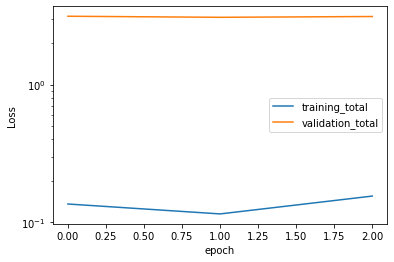

In [12]:
# plot loss/epoch for training and validation sets
print("Making basic validation plots")
training_total = plt.plot(training_losses_total, label='training_total')
validation_total = plt.plot(validation_losses_total, label='validation_total')
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
#plt.savefig("loss_plot.png")

tensor(-0.2204, grad_fn=<SelectBackward0>)
tensor([[0.4419, 0.8719]])
tensor(-0.1662, grad_fn=<SelectBackward0>)
tensor([[-0.3453, -0.9191]])
tensor(-0.1862, grad_fn=<SelectBackward0>)
tensor([[ 0.6666, -1.1748]])
tensor(-0.2683, grad_fn=<SelectBackward0>)
tensor([[-0.8645, -1.5499]])
tensor(-0.4164, grad_fn=<SelectBackward0>)
tensor([[-0.8328,  0.5895]])
tensor(-0.1770, grad_fn=<SelectBackward0>)
tensor([[-0.8530, -1.3692]])
tensor(-0.2444, grad_fn=<SelectBackward0>)
tensor([[1.7550, 0.1486]])
tensor(-0.3748, grad_fn=<SelectBackward0>)
tensor([[-1.2174, -1.6035]])
tensor(-2.0711, grad_fn=<SelectBackward0>)
tensor([[-0.1230,  1.8030]])
tensor(-0.1634, grad_fn=<SelectBackward0>)
tensor([[0.9358, 1.2094]])
tensor(-0.1313, grad_fn=<SelectBackward0>)
tensor([[-0.9826, -0.5341]])
tensor(-0.3277, grad_fn=<SelectBackward0>)
tensor([[-1.5051, -0.4738]])
tensor(-0.2861, grad_fn=<SelectBackward0>)
tensor([[ 0.8388, -1.1929]])
tensor(-0.2284, grad_fn=<SelectBackward0>)
tensor([[ 0.4339, -1.1469]]

tensor(-0.2512, grad_fn=<SelectBackward0>)
tensor([[-1.4310,  0.7027]])
tensor(-0.1563, grad_fn=<SelectBackward0>)
tensor([[ 1.3564, -1.1037]])
tensor(-0.1805, grad_fn=<SelectBackward0>)
tensor([[0.5881, 0.2709]])
tensor(-0.1758, grad_fn=<SelectBackward0>)
tensor([[ 0.4333, -0.0342]])
tensor(-0.1873, grad_fn=<SelectBackward0>)
tensor([[0.7911, 0.7287]])
tensor(-0.1830, grad_fn=<SelectBackward0>)
tensor([[-1.4798, -0.1252]])
tensor(-0.1589, grad_fn=<SelectBackward0>)
tensor([[-0.2099,  0.5031]])
tensor(-0.2321, grad_fn=<SelectBackward0>)
tensor([[0.5852, 1.3712]])
tensor(-0.2241, grad_fn=<SelectBackward0>)
tensor([[0.1278, 0.3555]])
tensor(-0.2448, grad_fn=<SelectBackward0>)
tensor([[-0.5282,  1.8172]])
tensor(-0.2152, grad_fn=<SelectBackward0>)
tensor([[-1.3654,  1.5957]])
tensor(-0.3210, grad_fn=<SelectBackward0>)
tensor([[-0.1365, -1.0700]])
tensor(-0.2729, grad_fn=<SelectBackward0>)
tensor([[0.1997, 1.4378]])
tensor(-0.2426, grad_fn=<SelectBackward0>)
tensor([[-1.3213, -0.0708]])
te

tensor(-0.2637, grad_fn=<SelectBackward0>)
tensor([[1.5430, 1.5077]])
tensor(-0.2118, grad_fn=<SelectBackward0>)
tensor([[-0.8123, -0.5358]])
tensor(-0.2733, grad_fn=<SelectBackward0>)
tensor([[-0.7830,  0.6854]])
tensor(-0.2030, grad_fn=<SelectBackward0>)
tensor([[1.1627, 1.1374]])
tensor(-0.1454, grad_fn=<SelectBackward0>)
tensor([[0.6164, 0.3815]])
tensor(-0.1770, grad_fn=<SelectBackward0>)
tensor([[ 1.2503, -0.3885]])
tensor(-0.1917, grad_fn=<SelectBackward0>)
tensor([[0.2698, 0.4271]])
tensor(-0.2538, grad_fn=<SelectBackward0>)
tensor([[-1.2547, -1.4309]])
tensor(-0.1900, grad_fn=<SelectBackward0>)
tensor([[1.1497, 1.2107]])
tensor(-0.2884, grad_fn=<SelectBackward0>)
tensor([[0.8654, 0.0354]])
tensor(-0.1912, grad_fn=<SelectBackward0>)
tensor([[1.1500, 0.3953]])
tensor(-0.2754, grad_fn=<SelectBackward0>)
tensor([[-1.1863,  0.1476]])
tensor(-0.3298, grad_fn=<SelectBackward0>)
tensor([[-1.3625, -0.9336]])
tensor(-0.2230, grad_fn=<SelectBackward0>)
tensor([[ 1.6529, -1.2286]])
tensor

tensor(-0.2302, grad_fn=<SelectBackward0>)
tensor([[-0.5784,  0.2575]])
tensor(-0.1750, grad_fn=<SelectBackward0>)
tensor([[-0.2992, -0.2767]])
tensor(-0.1860, grad_fn=<SelectBackward0>)
tensor([[1.1274, 0.3242]])
tensor(-0.2758, grad_fn=<SelectBackward0>)
tensor([[-0.4163,  0.0964]])
tensor(-0.2331, grad_fn=<SelectBackward0>)
tensor([[0.3909, 0.2233]])
tensor(-0.2123, grad_fn=<SelectBackward0>)
tensor([[-0.7114,  0.0780]])
tensor(-0.1905, grad_fn=<SelectBackward0>)
tensor([[ 1.0182, -0.0055]])
tensor(-0.1795, grad_fn=<SelectBackward0>)
tensor([[-1.2881, -1.1211]])
tensor(-0.1684, grad_fn=<SelectBackward0>)
tensor([[ 1.2171, -0.9431]])
tensor(-0.1558, grad_fn=<SelectBackward0>)
tensor([[ 1.0027, -0.8480]])
tensor(-0.1909, grad_fn=<SelectBackward0>)
tensor([[-1.0664,  0.4255]])
tensor(-0.1643, grad_fn=<SelectBackward0>)
tensor([[-1.1837, -1.1153]])
tensor(-0.1567, grad_fn=<SelectBackward0>)
tensor([[-0.7066, -0.0287]])
tensor(-0.2111, grad_fn=<SelectBackward0>)
tensor([[-0.1010, -0.0659

tensor(-0.2308, grad_fn=<SelectBackward0>)
tensor([[-1.0178, -0.0753]])
tensor(-0.2546, grad_fn=<SelectBackward0>)
tensor([[0.5516, 0.1060]])
tensor(-0.2767, grad_fn=<SelectBackward0>)
tensor([[ 1.0502, -0.5857]])
tensor(-0.1672, grad_fn=<SelectBackward0>)
tensor([[ 0.2551, -0.9399]])
tensor(-0.1529, grad_fn=<SelectBackward0>)
tensor([[0.5734, 1.1579]])
tensor(-0.2200, grad_fn=<SelectBackward0>)
tensor([[0.2198, 1.1684]])
tensor(-0.2515, grad_fn=<SelectBackward0>)
tensor([[-1.0643, -0.4626]])
tensor(-0.2409, grad_fn=<SelectBackward0>)
tensor([[1.0011, 1.1353]])
tensor(-1.0046, grad_fn=<SelectBackward0>)
tensor([[-1.1662,  1.7928]])
tensor(-0.1384, grad_fn=<SelectBackward0>)
tensor([[0.2956, 0.8066]])
tensor(-0.2006, grad_fn=<SelectBackward0>)
tensor([[-0.3725, -0.6776]])
tensor(-0.2276, grad_fn=<SelectBackward0>)
tensor([[1.0918, 0.2742]])
tensor(-0.4004, grad_fn=<SelectBackward0>)
tensor([[-0.8865, -1.1888]])
tensor(-0.2026, grad_fn=<SelectBackward0>)
tensor([[0.8492, 1.5106]])
tensor

tensor([[ 0.4315, -1.6694]])
tensor(-0.3392, grad_fn=<SelectBackward0>)
tensor([[1.1531, 0.3303]])
tensor(-0.1783, grad_fn=<SelectBackward0>)
tensor([[-1.0947,  0.1836]])
tensor(-0.2707, grad_fn=<SelectBackward0>)
tensor([[1.2135, 1.2733]])
tensor(-0.1462, grad_fn=<SelectBackward0>)
tensor([[ 0.9124, -0.2702]])
tensor(-0.1854, grad_fn=<SelectBackward0>)
tensor([[ 0.3768, -1.0020]])
tensor(-0.1940, grad_fn=<SelectBackward0>)
tensor([[1.0030, 1.1502]])
tensor(-0.1821, grad_fn=<SelectBackward0>)
tensor([[ 2.8814, -0.9994]])
tensor(-0.2752, grad_fn=<SelectBackward0>)
tensor([[-0.2798,  0.5832]])
tensor(-0.1682, grad_fn=<SelectBackward0>)
tensor([[ 1.1492, -1.2405]])
tensor(-0.2508, grad_fn=<SelectBackward0>)
tensor([[-1.8273,  0.2133]])
tensor(-0.1530, grad_fn=<SelectBackward0>)
tensor([[-0.4001, -1.2145]])
tensor(-0.1574, grad_fn=<SelectBackward0>)
tensor([[-1.8526,  0.9653]])
tensor(-0.2340, grad_fn=<SelectBackward0>)
tensor([[-0.0626,  0.0051]])
tensor(-0.1569, grad_fn=<SelectBackward0>

tensor(-0.2423, grad_fn=<SelectBackward0>)
tensor([[ 1.5767, -0.8091]])
tensor(-0.1464, grad_fn=<SelectBackward0>)
tensor([[-0.1815, -0.7108]])
tensor(-0.2372, grad_fn=<SelectBackward0>)
tensor([[0.8525, 1.4590]])
tensor(-0.3055, grad_fn=<SelectBackward0>)
tensor([[-0.7079, -0.8995]])
tensor(-0.3041, grad_fn=<SelectBackward0>)
tensor([[-0.4526, -0.6442]])
tensor(-0.2104, grad_fn=<SelectBackward0>)
tensor([[-0.8763, -0.9930]])
tensor(-0.1869, grad_fn=<SelectBackward0>)
tensor([[0.8563, 0.7016]])
tensor(-0.1824, grad_fn=<SelectBackward0>)
tensor([[ 0.6098, -0.3609]])
tensor(-0.2236, grad_fn=<SelectBackward0>)
tensor([[0.2420, 1.2053]])
tensor(-0.3255, grad_fn=<SelectBackward0>)
tensor([[-0.0628, -0.1910]])
tensor(-0.2123, grad_fn=<SelectBackward0>)
tensor([[-0.0216,  1.0065]])
tensor(-0.2065, grad_fn=<SelectBackward0>)
tensor([[-0.1327, -1.1988]])
tensor(-0.1706, grad_fn=<SelectBackward0>)
tensor([[-1.5103,  0.3390]])
tensor(-0.1880, grad_fn=<SelectBackward0>)
tensor([[ 0.2540, -0.8989]]

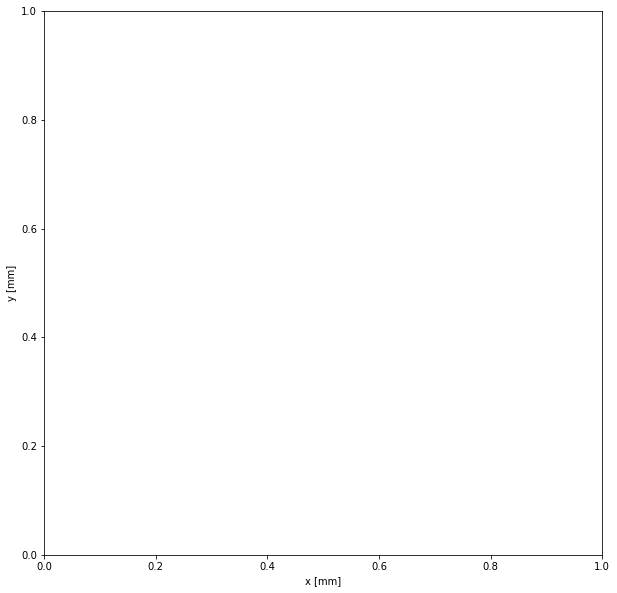

In [166]:
plt.figure(figsize=(10,10))
#plt.xlim(-10.0,10.0)
#plt.ylim(-10.0,10.0)
#plt.xlim(-2.0,2.0)
#plt.ylim(-2.0,2.0)
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")

output_pos = []
output_pos = []
for i, data in enumerate(loader_test):
        output = model(data.x, data.edge_index)
        
        #print(output[0][1])
        #print(data.y)
        
#plt.scatter(y_train[:,0], y_train[:,1], alpha=.5)
#plt.scatter(model(loader_train).detach().numpy()[:,0], model(loader_train).detach().numpy()[:,1], alpha=.5)

TypeError: forward() missing 1 required positional argument: 'edge_index'

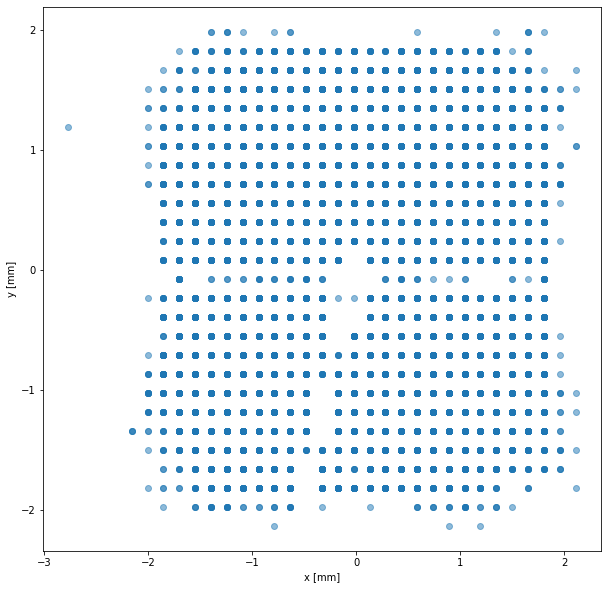

In [12]:
plt.figure(figsize=(10,10))
#plt.xlim(-10.0,10.0)
#plt.ylim(-10.0,10.0)
#plt.xlim(-2.0,2.0)
#plt.ylim(-2.0,2.0)
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")

plt.scatter(y_train[:,0], y_train[:,1], alpha=.5)
plt.scatter(model(loader_train).detach().numpy()[:,0], model(loader_train).detach().numpy()[:,1], alpha=.5)

#plt.savefig('/home/federico/Scrivania/croci450_2d.png')

In [ ]:
plt.figure(figsize=(10,10))
#plt.xlim(-10.0,10.0)
#plt.ylim(-10.0,10.0)
#plt.xlim(-2.0,2.0)
#plt.ylim(-2.0,2.0)
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")

model.eval()

plt.scatter(y_test[:,0], y_test[:,1], alpha=.5)
plt.scatter(model(x_test).detach().numpy()[:,0], model(x_test).detach().numpy()[:,1], alpha=.5)

#plt.savefig('/home/federico/Scrivania/croci450_2d.png')

In [ ]:
epochs        = 1
n_feat        = 2
n_hid         = 16
n_class       = 9
drop_out_p    = 0.0

class GNN(nn.Module):
    def __init__(self, n_feat, n_hid, n_class, drop_out_p):
        super(GNN, self).__init__()

        self.gc1 = GCNConv(n_feat, n_hid)
        self.gc2 = GCNConv(n_hid, n_class)
        self.dropout = drop_out_p
        self.LinearLayer = nn.Linear(n_feat, 2)

    def forward(self, x, edge_index):
        x = F.relu(self.gc1(x, edge_index))

        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, edge_index)
        x = self.LinearLayer(torch.transpose(x, 2, 1))

        return torch.transpose(x, 2, 1)
    
model = GNN(n_feat=n_feat, n_hid=n_hid, n_class=n_class, drop_out_p=drop_out_p)